<a href="https://www.kaggle.com/code/gzdekzlkaya/decision-tree-based-migraine-type-classification?scriptVersionId=211188382" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Business Problem

Our goal is to develop a model that classifies migraine types based on symptoms using machine learning algorithms, contributing to the diagnosis and treatment process of migraines.

# Dataset Story

This dataset contains 400 medical records of individuals diagnosed with various migraine-related pathologies. The data was recorded by trained medical personnel at Centro Materno Infantil de Soledad during the first quarter of 2013. This compiled database includes information on 23 symptoms required for migraine classification.

# Required Libraries and Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, roc_curve, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from scipy import stats
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
# pip install skompiler
# pip install xgboost
# pip install lightgbm


warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("/kaggle/input/migraine-dataset/migraine_data.csv")
df.shape

(400, 24)

In [3]:
df.head()

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,Visual,Sensory,Dysphasia,Dysarthria,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF,Type
0,30,1,5,1,1,2,1,0,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,Typical aura with migraine
1,50,3,5,1,1,3,1,1,1,1,2,1,0,0,1,0,0,0,0,0,0,0,0,Typical aura with migraine
2,53,2,1,1,1,2,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,Typical aura with migraine
3,45,3,5,1,1,3,1,0,1,1,2,2,0,0,1,0,0,0,0,0,0,0,0,Typical aura with migraine
4,53,1,1,1,1,2,1,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,1,Typical aura with migraine


# Exploratory Data Analysis (EDA)

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

check_df(df)

# Capitalize column headers:
df.columns = [col.upper() for col in df.columns]
df.head()

##################### Shape #####################
(400, 24)
##################### Types #####################
Age             int64
Duration        int64
Frequency       int64
Location        int64
Character       int64
Intensity       int64
Nausea          int64
Vomit           int64
Phonophobia     int64
Photophobia     int64
Visual          int64
Sensory         int64
Dysphasia       int64
Dysarthria      int64
Vertigo         int64
Tinnitus        int64
Hypoacusis      int64
Diplopia        int64
Defect          int64
Ataxia          int64
Conscience      int64
Paresthesia     int64
DPF             int64
Type           object
dtype: object
##################### Head #####################
   Age  Duration  Frequency  Location  Character  Intensity  Nausea  Vomit  \
0   30         1          5         1          1          2       1      0   
1   50         3          5         1          1          3       1      1   
2   53         2          1         1          1          2      

,AGE,DURATION,FREQUENCY,LOCATION,CHARACTER,INTENSITY,NAUSEA,VOMIT,PHONOPHOBIA,PHOTOPHOBIA,VISUAL,SENSORY,DYSPHASIA,DYSARTHRIA,VERTIGO,TINNITUS,HYPOACUSIS,DIPLOPIA,DEFECT,ATAXIA,CONSCIENCE,PARESTHESIA,DPF,TYPE
0,30,1,5,1,1,2,1,0,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,Typical aura with migraine
1,50,3,5,1,1,3,1,1,1,1,2,1,0,0,1,0,0,0,0,0,0,0,0,Typical aura with migraine
2,53,2,1,1,1,2,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,Typical aura with migraine
3,45,3,5,1,1,3,1,0,1,1,2,2,0,0,1,0,0,0,0,0,0,0,0,Typical aura with migraine
4,53,1,1,1,1,2,1,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,1,Typical aura with migraine


### Detection of Numeric and Categorical Variables

In [5]:
def grab_col_names(dataframe, cat_th=5, car_th=10):
    """
    It provides the names of categorical, numeric, and categorical but cardinal variables in the dataset.
    Note: Categorical variables also include numerically represented categorical variables.
    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    # Numeric columns with fewer unique values than cat_th are considered categorical
    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    # Optional: Include specific columns like 'Visual' and 'Intensity' as categorical
    forced_cat_cols = ['VISUAL', 'INTENSITY']
    num_but_cat += [col for col in forced_cat_cols if col in dataframe.columns]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Convert the ‘Duration’ variable to numeric:
    if 'DURATION' in dataframe.columns and 'DURATION' not in num_cols:
        num_cols.append('DURATION')
    if 'DURATION' in cat_cols:
        cat_cols.remove('DURATION')

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 400
Variables: 24
cat_cols: 22
num_cols: 3
cat_but_car: 0
num_but_cat: 22


### Analysis of Categorical Variables

                               TYPE  Ratio
TYPE                                      
Typical aura with migraine      247 61.750
Migraine without aura            60 15.000
Familial hemiplegic migraine     24  6.000
Typical aura without migraine    20  5.000
Basilar-type aura                18  4.500
Other                            17  4.250
Sporadic hemiplegic migraine     14  3.500
##########################################


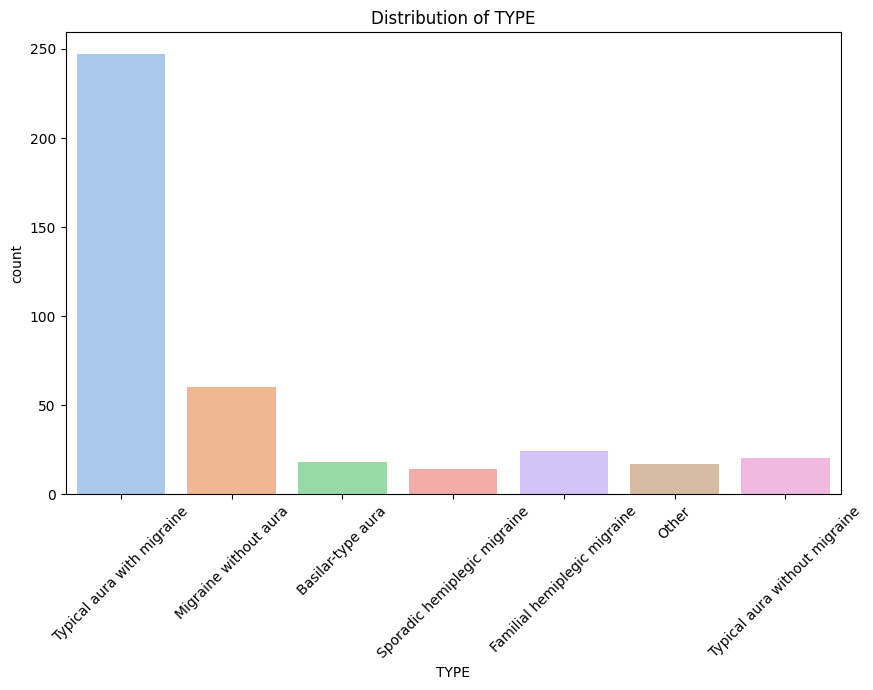

          LOCATION  Ratio
LOCATION                 
1              371 92.750
0               20  5.000
2                9  2.250
##########################################


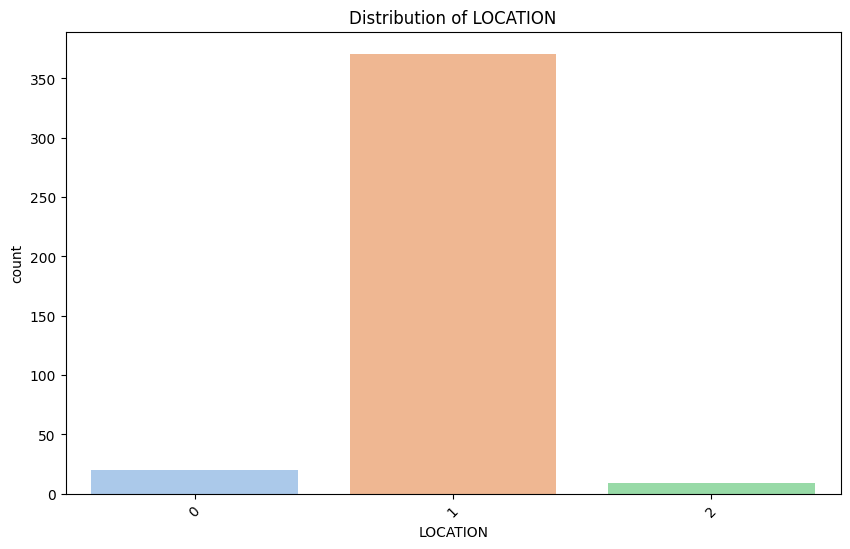

           CHARACTER  Ratio
CHARACTER                  
1                369 92.250
0                 20  5.000
2                 11  2.750
##########################################


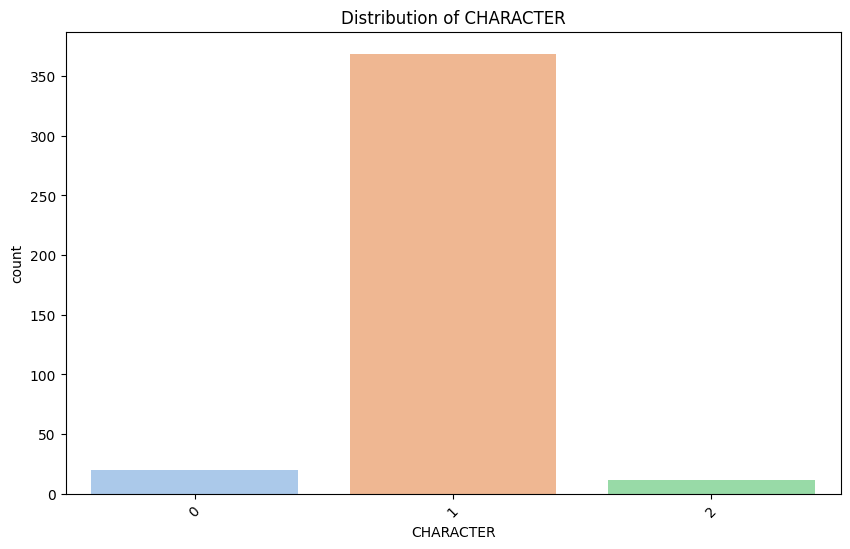

           INTENSITY  Ratio
INTENSITY                  
3                236 59.000
2                136 34.000
0                 20  5.000
1                  8  2.000
##########################################


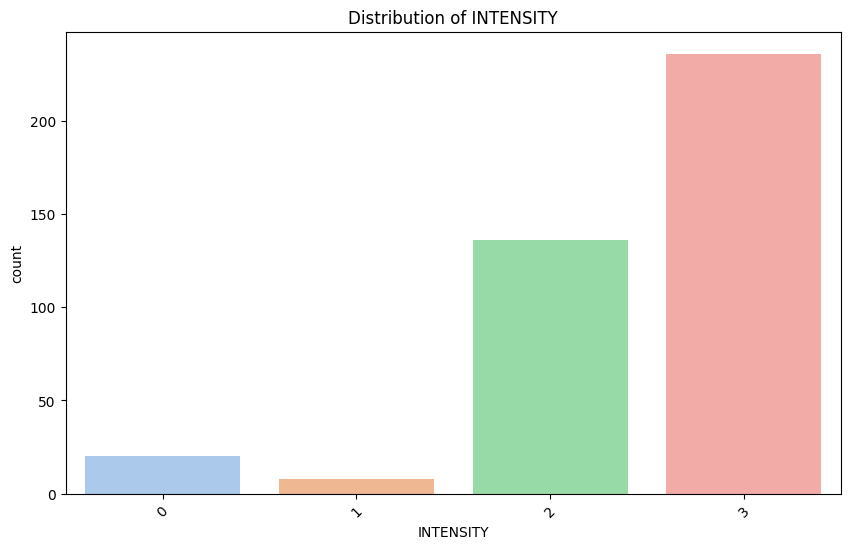

        NAUSEA  Ratio
NAUSEA               
1          395 98.750
0            5  1.250
##########################################


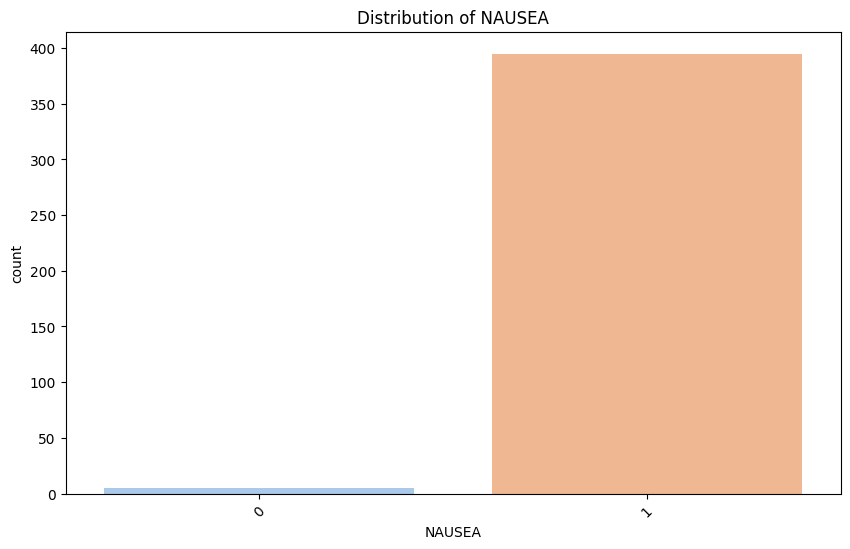

       VOMIT  Ratio
VOMIT              
0        271 67.750
1        129 32.250
##########################################


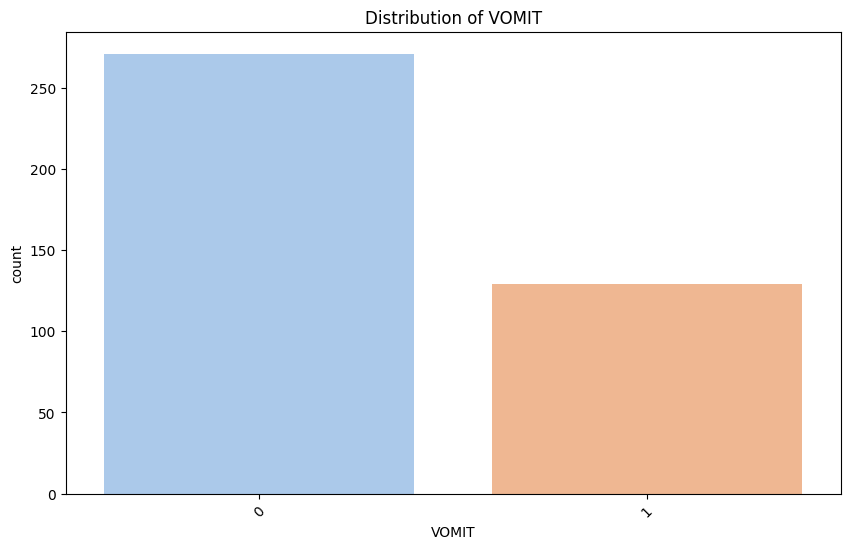

             PHONOPHOBIA  Ratio
PHONOPHOBIA                    
1                    391 97.750
0                      9  2.250
##########################################


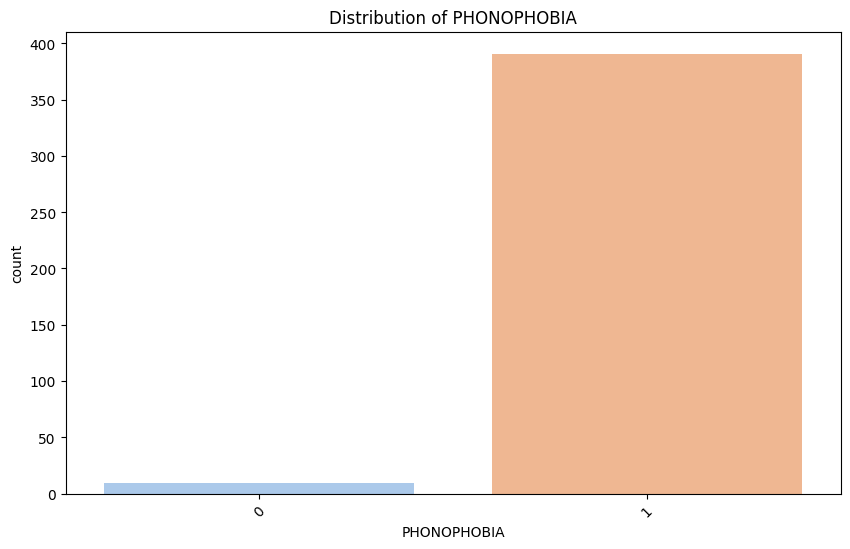

             PHOTOPHOBIA  Ratio
PHOTOPHOBIA                    
1                    392 98.000
0                      8  2.000
##########################################


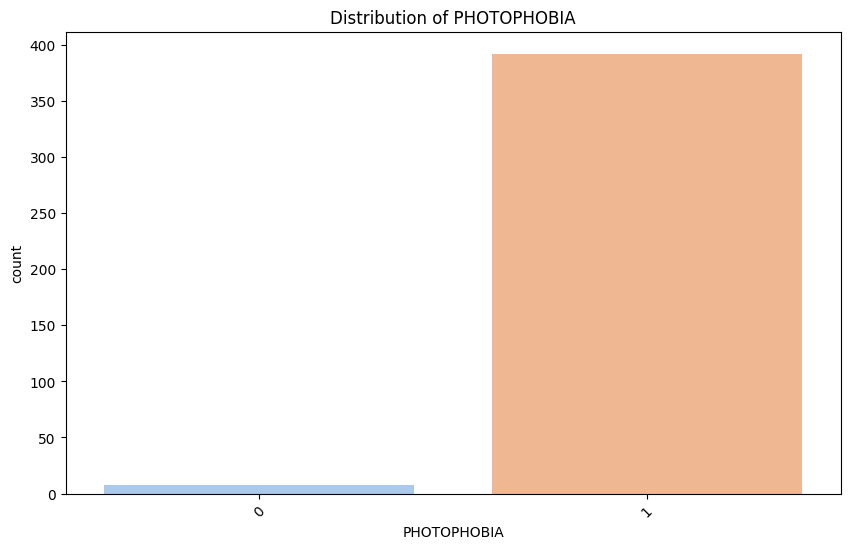

         SENSORY  Ratio
SENSORY                
0            311 77.750
1             57 14.250
2             32  8.000
##########################################


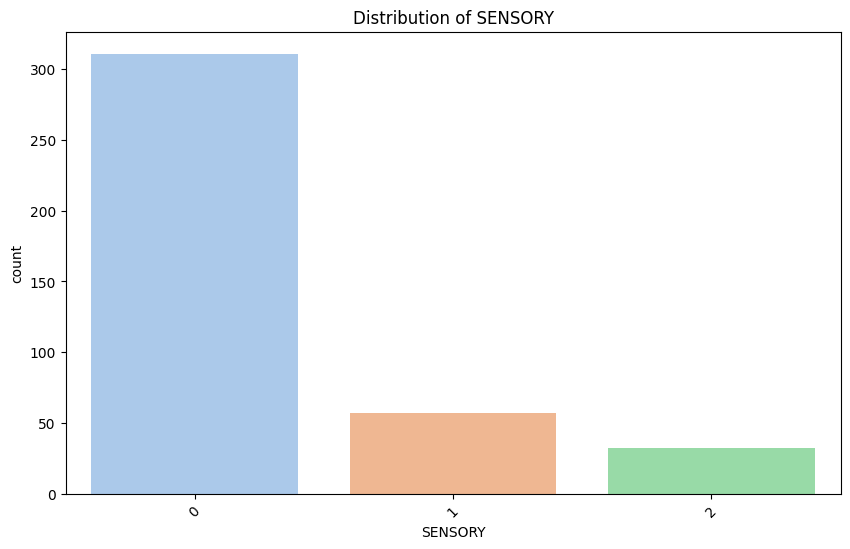

           DYSPHASIA  Ratio
DYSPHASIA                  
0                385 96.250
1                 15  3.750
##########################################


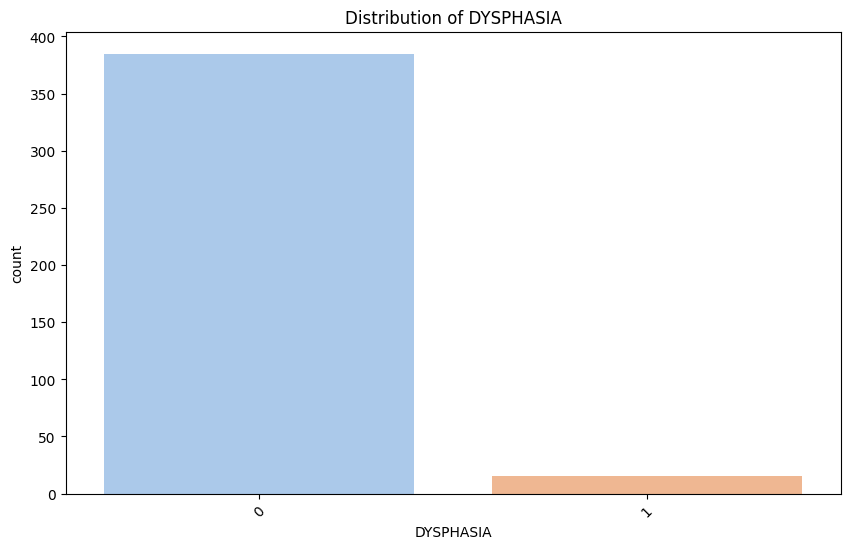

            DYSARTHRIA  Ratio
DYSARTHRIA                   
0                  399 99.750
1                    1  0.250
##########################################


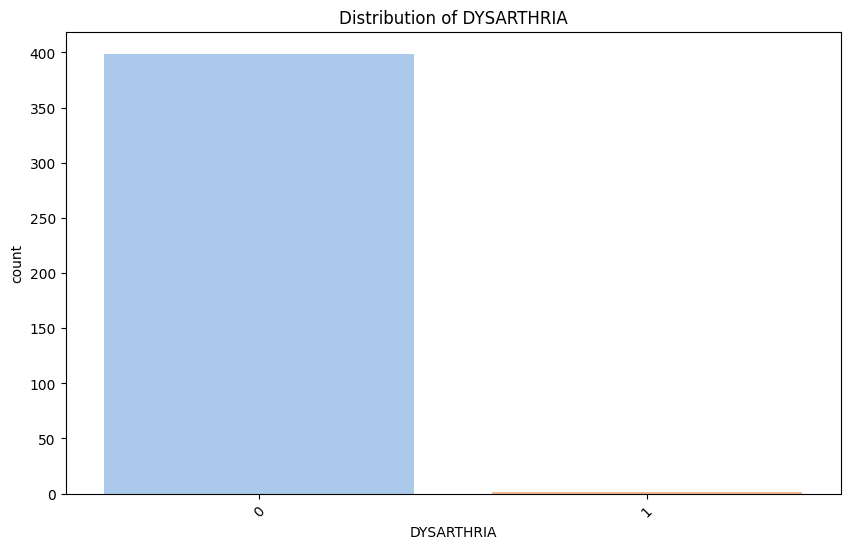

         VERTIGO  Ratio
VERTIGO                
0            350 87.500
1             50 12.500
##########################################


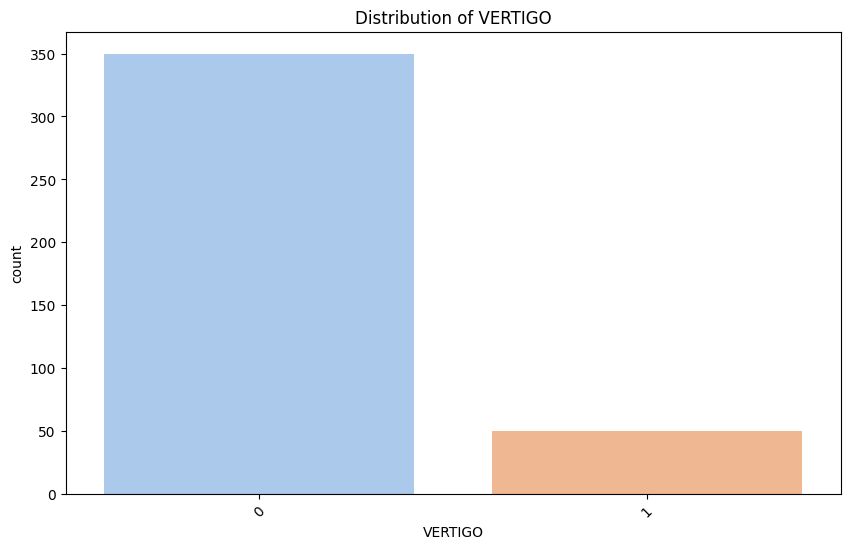

          TINNITUS  Ratio
TINNITUS                 
0              376 94.000
1               24  6.000
##########################################


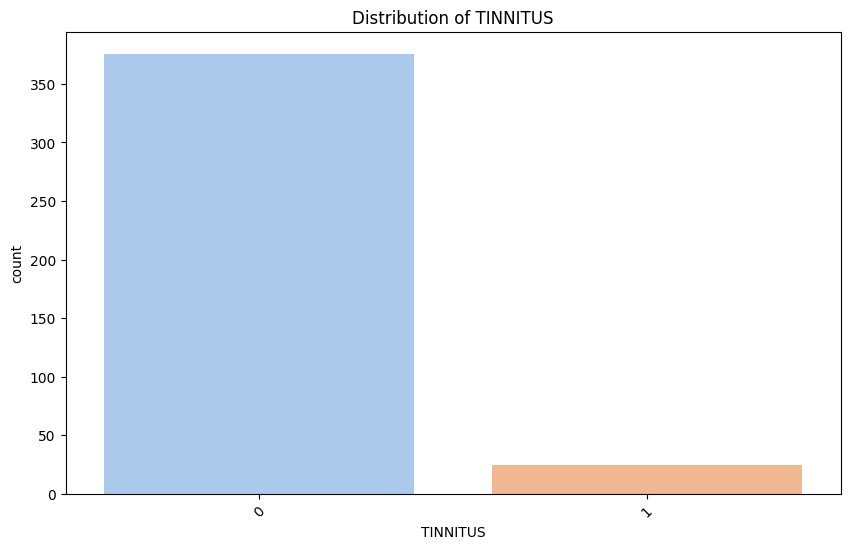

            HYPOACUSIS  Ratio
HYPOACUSIS                   
0                  394 98.500
1                    6  1.500
##########################################


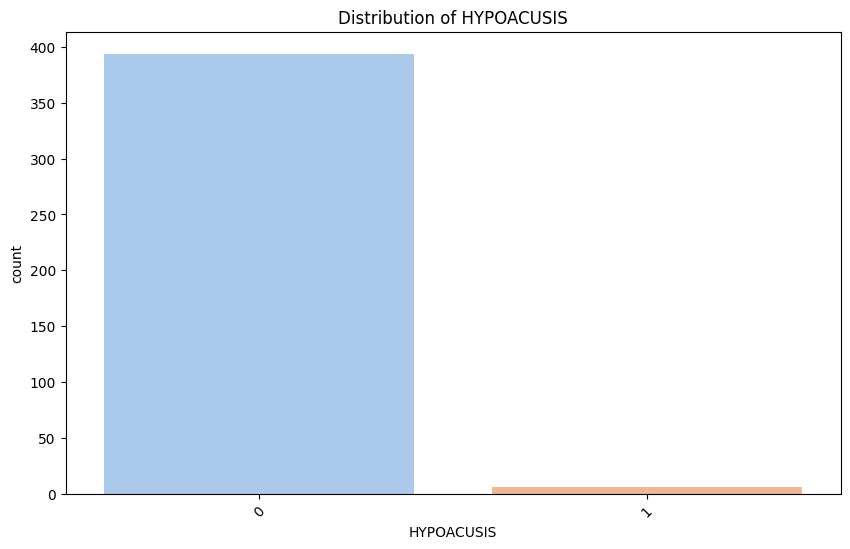

          DIPLOPIA  Ratio
DIPLOPIA                 
0              398 99.500
1                2  0.500
##########################################


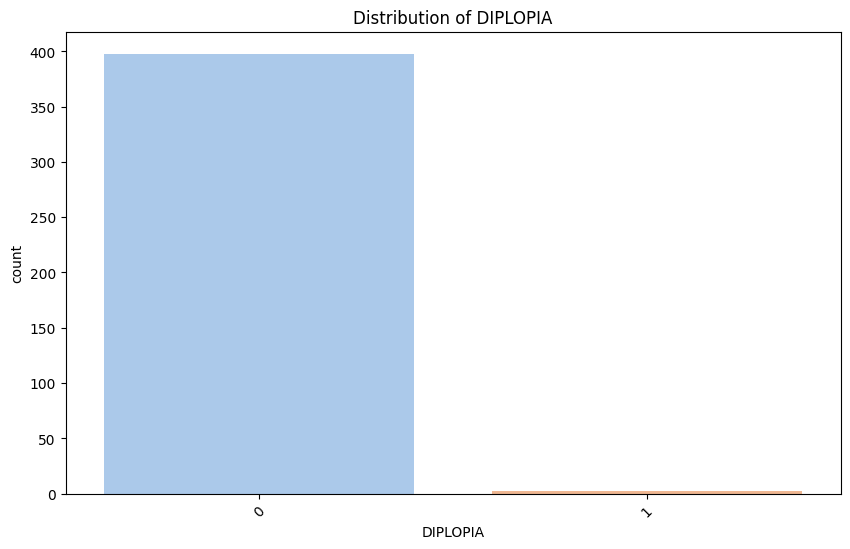

        DEFECT  Ratio
DEFECT               
0          394 98.500
1            6  1.500
##########################################


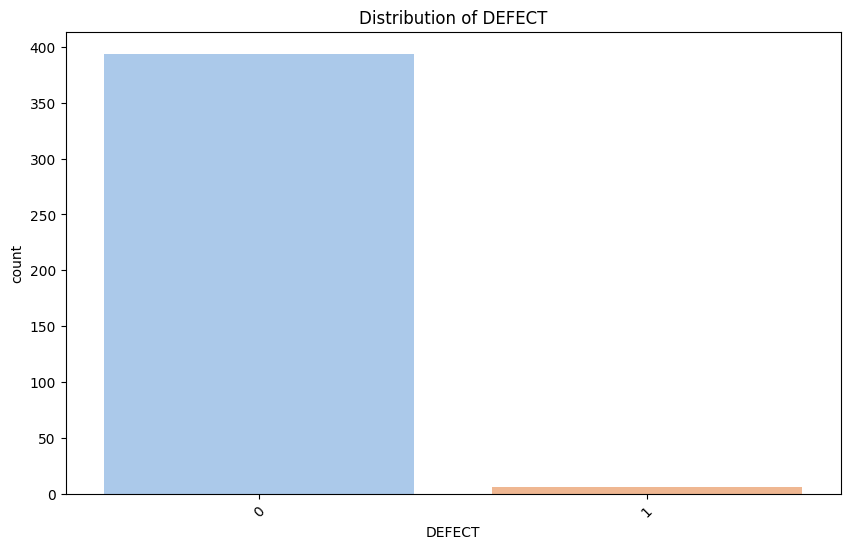

        ATAXIA   Ratio
ATAXIA                
0          400 100.000
##########################################


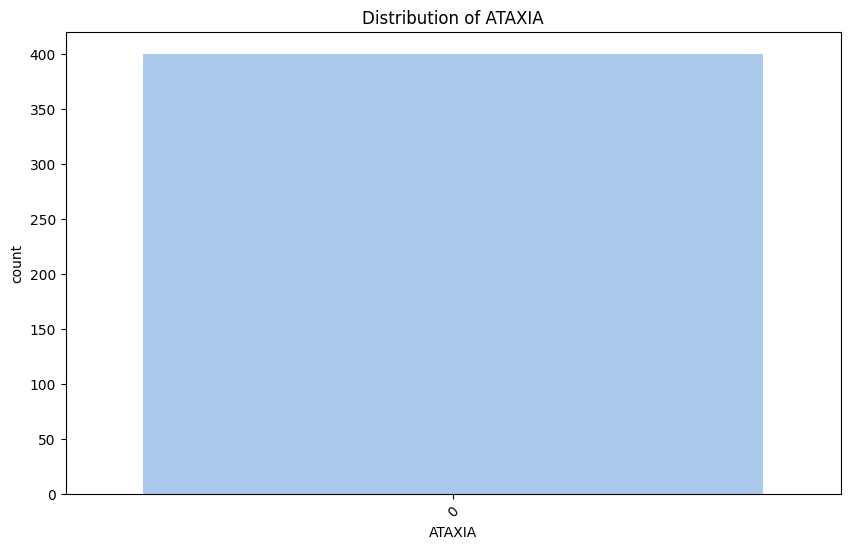

            CONSCIENCE  Ratio
CONSCIENCE                   
0                  393 98.250
1                    7  1.750
##########################################


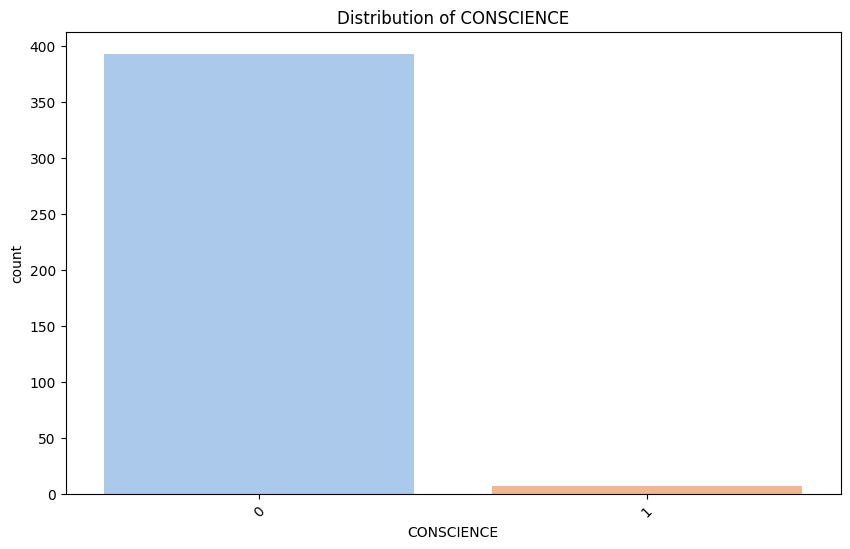

             PARESTHESIA  Ratio
PARESTHESIA                    
0                    397 99.250
1                      3  0.750
##########################################


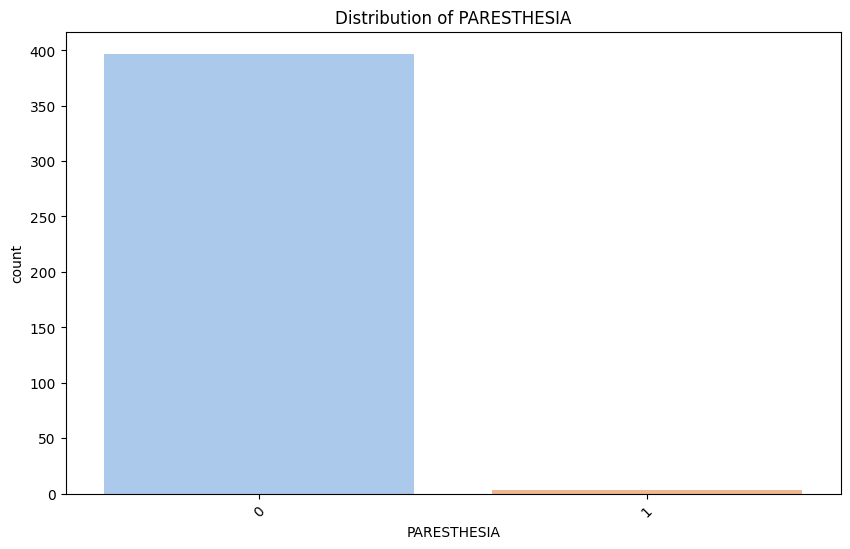

     DPF  Ratio
DPF            
0    236 59.000
1    164 41.000
##########################################


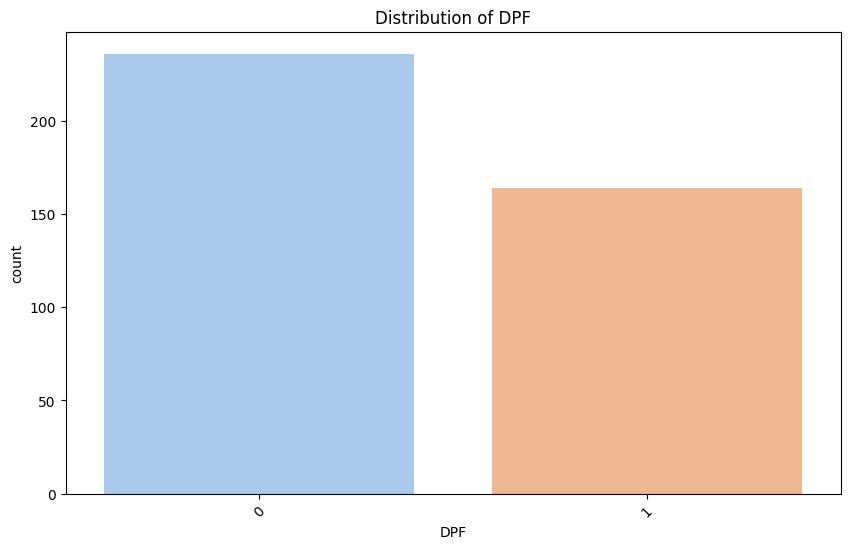

        VISUAL  Ratio
VISUAL               
2          176 44.000
1           96 24.000
0           82 20.500
3           37  9.250
4            9  2.250
##########################################


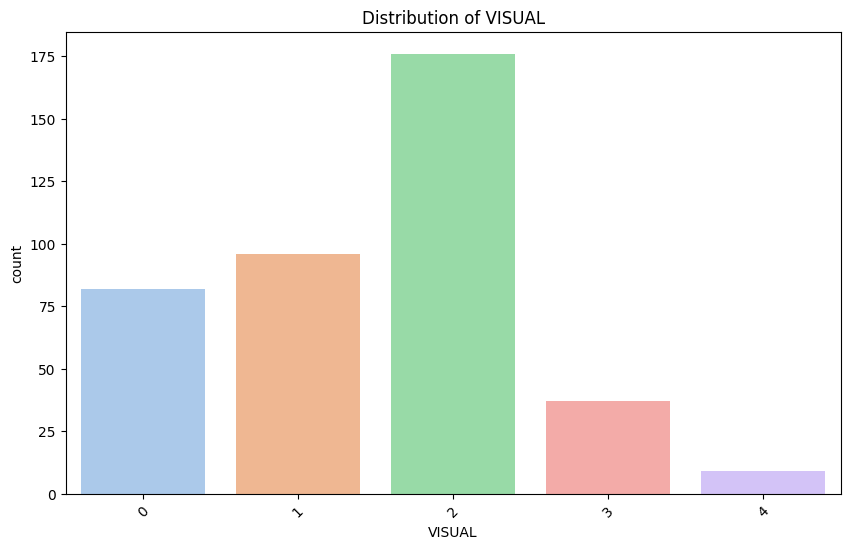

           INTENSITY  Ratio
INTENSITY                  
3                236 59.000
2                136 34.000
0                 20  5.000
1                  8  2.000
##########################################


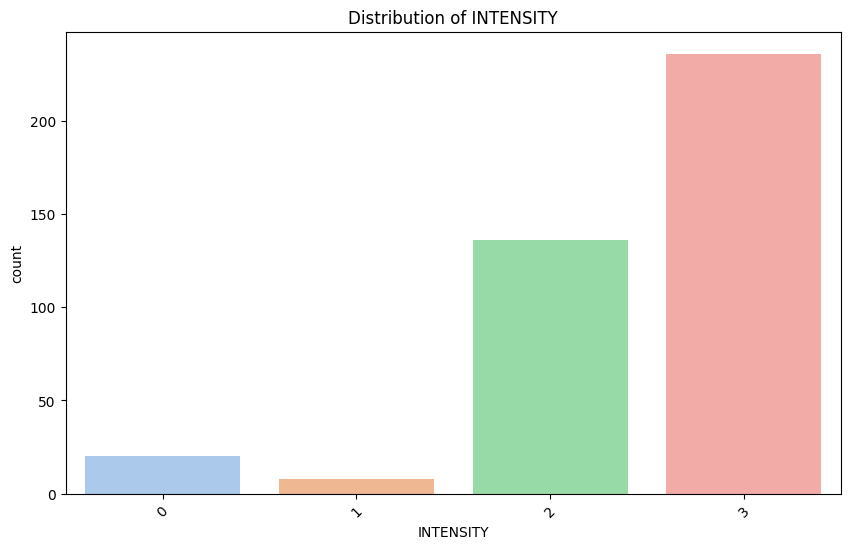

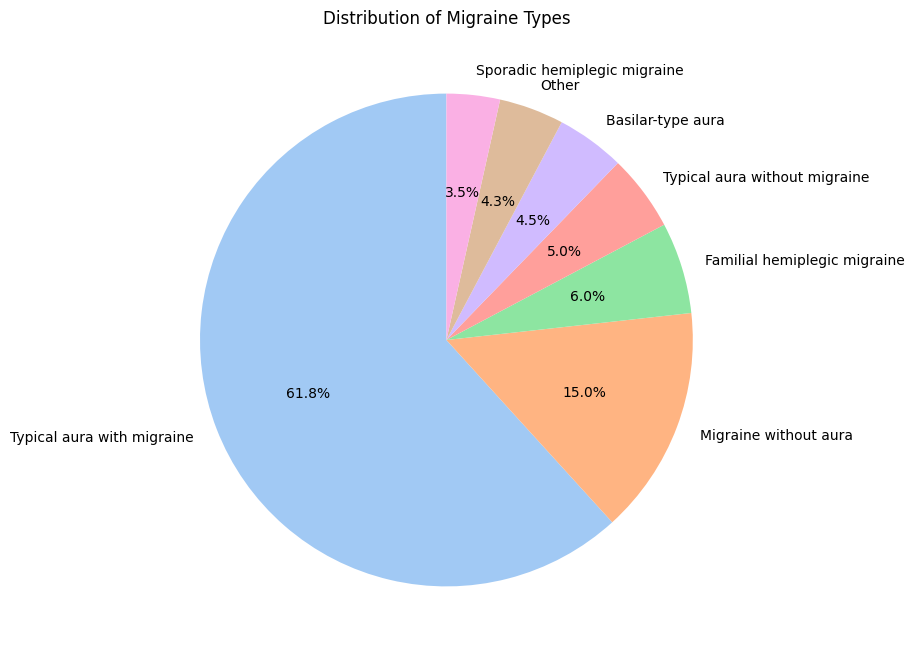

In [6]:
def cat_summary(dataframe, col_name, plot=False):
    summary = pd.DataFrame({
        col_name: dataframe[col_name].value_counts(),
        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)
    })
    print(summary)
    print("##########################################")

    if plot:
        plt.figure(figsize=(10, 6))  # Set the plot size
        # Choose a pastel palette for unique colors        
        sns.countplot(x=dataframe[col_name], data=dataframe, palette="pastel")
        plt.xticks(rotation=45)  # Rotate the labels by 45 degrees
        plt.title(f"Distribution of {col_name}")  # Add a title
        plt.show()

# Run the cat_summary function for all categorical columns:
for col in cat_cols:
    cat_summary(df, col, plot=True)

# To visualize the distribution of migraine types:
# Choose a pastel color palette for the pie chartcolors:
colors = sns.color_palette("pastel")

# Creating a pie chart
df['TYPE'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',  # Display percentages
    startangle=90,  # Set the starting angle
    colors=colors,  # Use pastel colors
    figsize=(8, 8)  # Set the dimensions of the plot
)

plt.title("Distribution of Migraine Types")  # Add a title
plt.ylabel('')  # Remove the y-axis label
plt.show()

Type: “Typical aura with migraine” is the most common class (61.75%), followed by “Migraine without aura.” Other classes occur at lower frequencies.
Location and Character: Most patients reported unilateral pain and a throbbing pain character.
Nausea, Phonophobia, and Photophobia: These symptoms are very common and present in most cases.
Ataxia and Diplopia: These features are very rarely seen.
Visual: Typically, there are 2 visual symptoms.

### Analysis of Numeric Variables

count   400.000
mean     31.705
std      12.139
min      15.000
5%       17.000
10%      18.000
20%      21.000
30%      23.000
40%      26.000
50%      28.000
60%      33.000
70%      37.000
80%      43.000
90%      50.000
95%      53.050
99%      67.010
max      77.000
Name: AGE, dtype: float64


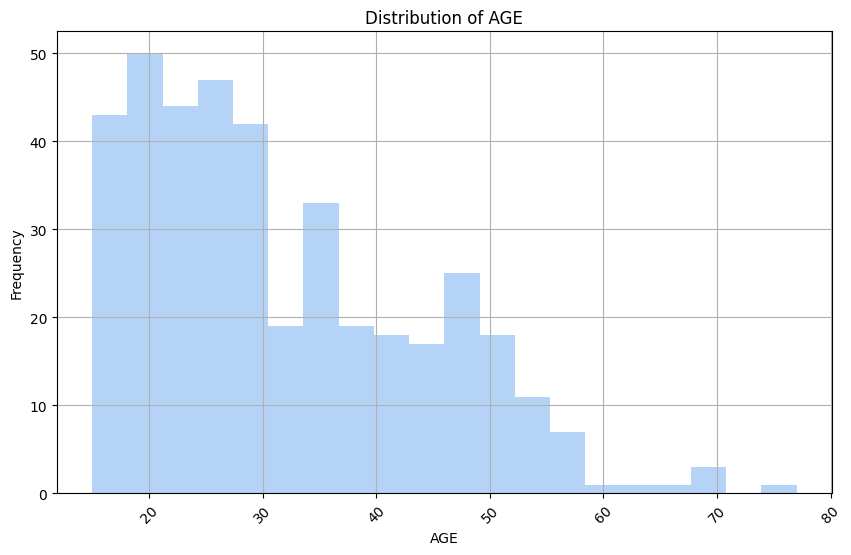

count   400.000
mean      2.365
std       1.676
min       1.000
5%        1.000
10%       1.000
20%       1.000
30%       1.000
40%       1.000
50%       2.000
60%       2.000
70%       3.000
80%       5.000
90%       5.000
95%       5.000
99%       7.000
max       8.000
Name: FREQUENCY, dtype: float64


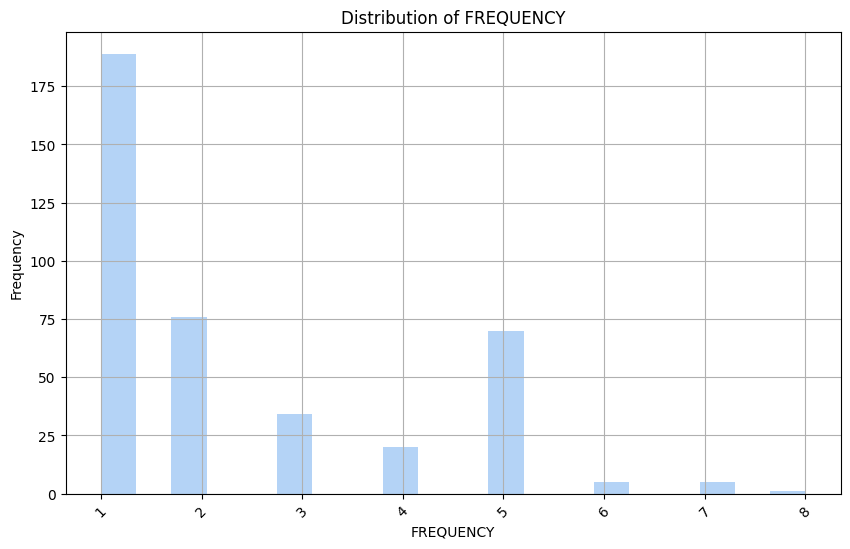

count   400.000
mean      1.610
std       0.771
min       1.000
5%        1.000
10%       1.000
20%       1.000
30%       1.000
40%       1.000
50%       1.000
60%       2.000
70%       2.000
80%       2.000
90%       3.000
95%       3.000
99%       3.000
max       3.000
Name: DURATION, dtype: float64


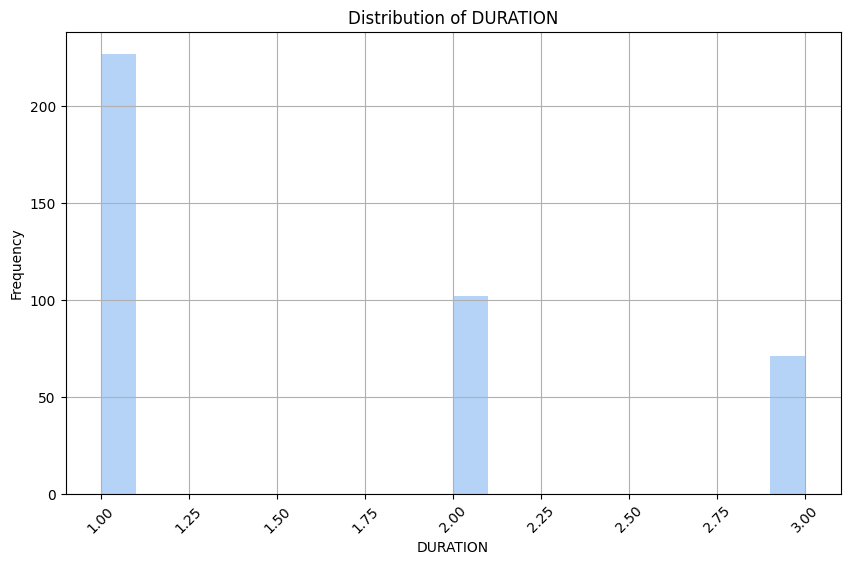

In [7]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        plt.figure(figsize=(10, 6)) 
        color = sns.color_palette("pastel")[0] 
        dataframe[numerical_col].hist(bins=20, color=color, alpha=0.8)

        plt.xlabel(numerical_col)
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {numerical_col}")
        plt.xticks(rotation=45) 
        plt.show()

# Run the num_summary function for numeric variables only:
for col in num_cols:
    num_summary(df, col, plot=True)

Age: The majority are between 15-40 years old, with an average age around 31.
Frequency: The frequency of episodes is mostly between 1 and 4, but in a few cases, it can go up to 8.
Duration: Most migraine episodes last 1 or 2 days.

### Outlier Analysis

In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Outlier analysis and capping for numeric variables
for col in num_cols:
    print(col, check_outlier(df, col))  
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

AGE False
FREQUENCY False
DURATION False


### Correlation Analysis

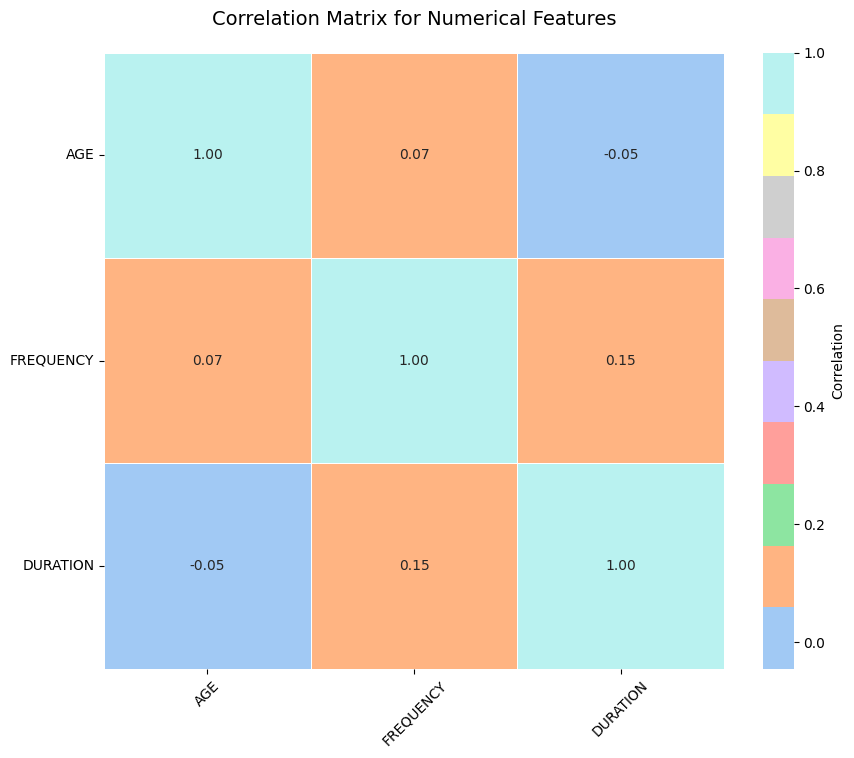

In [9]:
# Calculate the correlation matrix for numeric columns:
corr_matrix = df[num_cols].corr()

# Plot a heatmap for the correlation matrix:
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix,
            annot=True,             
            cmap=sns.color_palette("pastel", as_cmap=True),
            fmt=".2f",
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'} 
)

plt.title("Correlation Matrix for Numerical Features", fontsize=14, pad=20)  
plt.xticks(rotation=45) 
plt.yticks(rotation=0)
plt.show()

In the correlation analysis between numeric variables, no strong relationships were found; the correlation coefficients are generally low. This indicates that the numeric variables are independent of each other, and we may need to perform further feature engineering or explore interactions with other variables to improve the performance of our model.

### Analysis of the Relationship Between Categorical Variables and the Target Variable (TYPE)

'TYPE' column has 7 unique values.
Valid categorical columns: ['TYPE', 'LOCATION', 'CHARACTER', 'INTENSITY', 'NAUSEA', 'VOMIT', 'PHONOPHOBIA', 'PHOTOPHOBIA', 'SENSORY', 'DYSPHASIA', 'DYSARTHRIA', 'VERTIGO', 'TINNITUS', 'HYPOACUSIS', 'DIPLOPIA', 'DEFECT', 'CONSCIENCE', 'PARESTHESIA', 'DPF', 'VISUAL', 'INTENSITY']


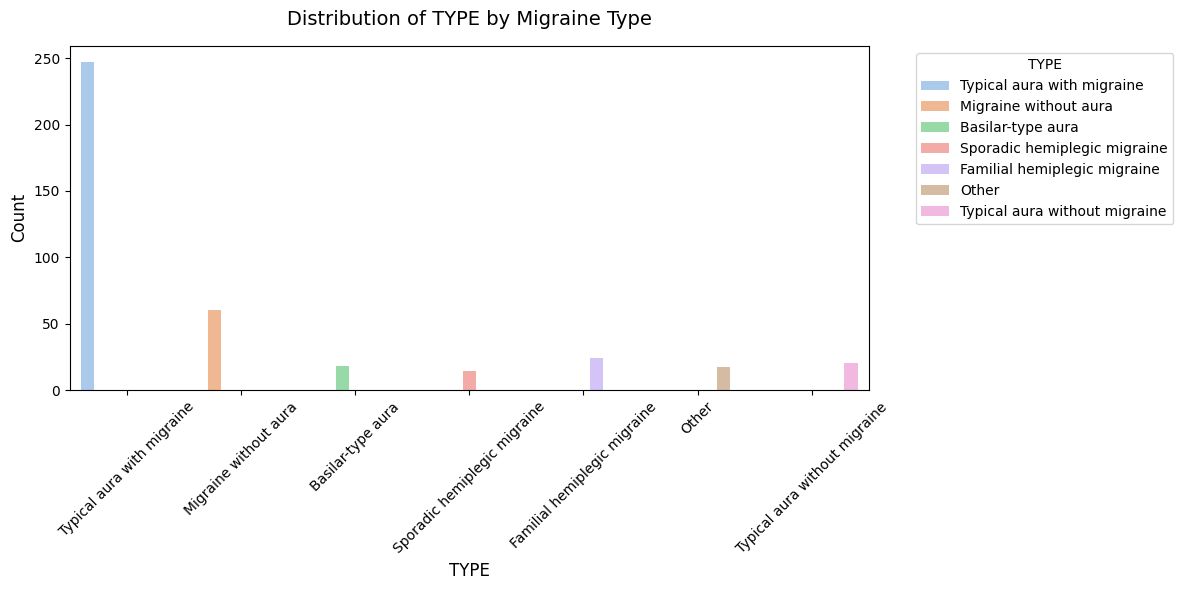

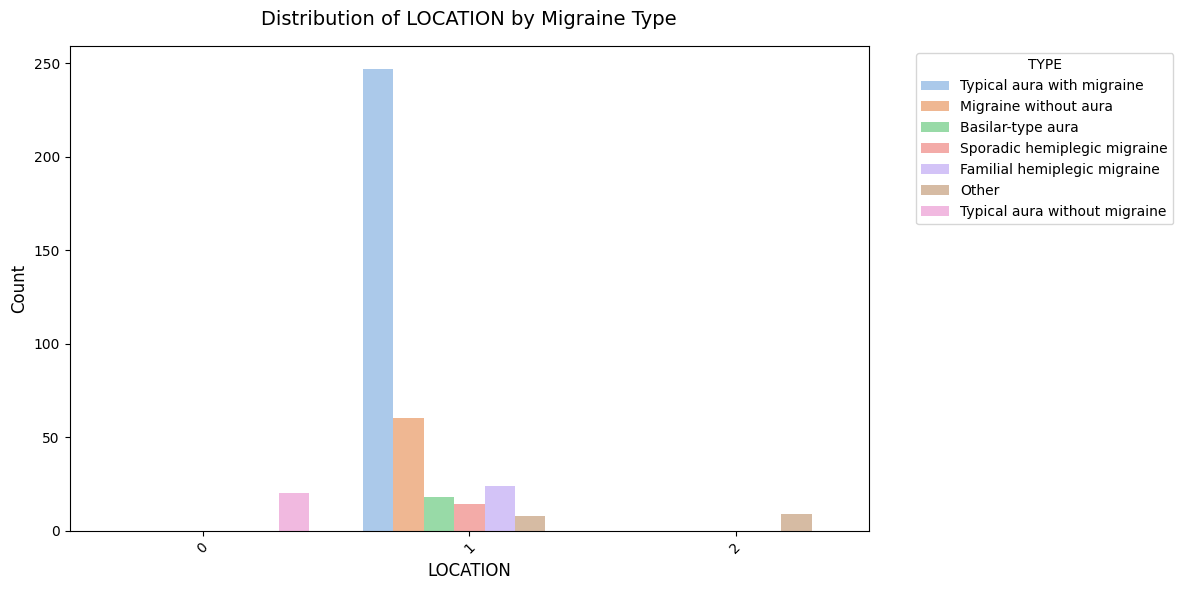

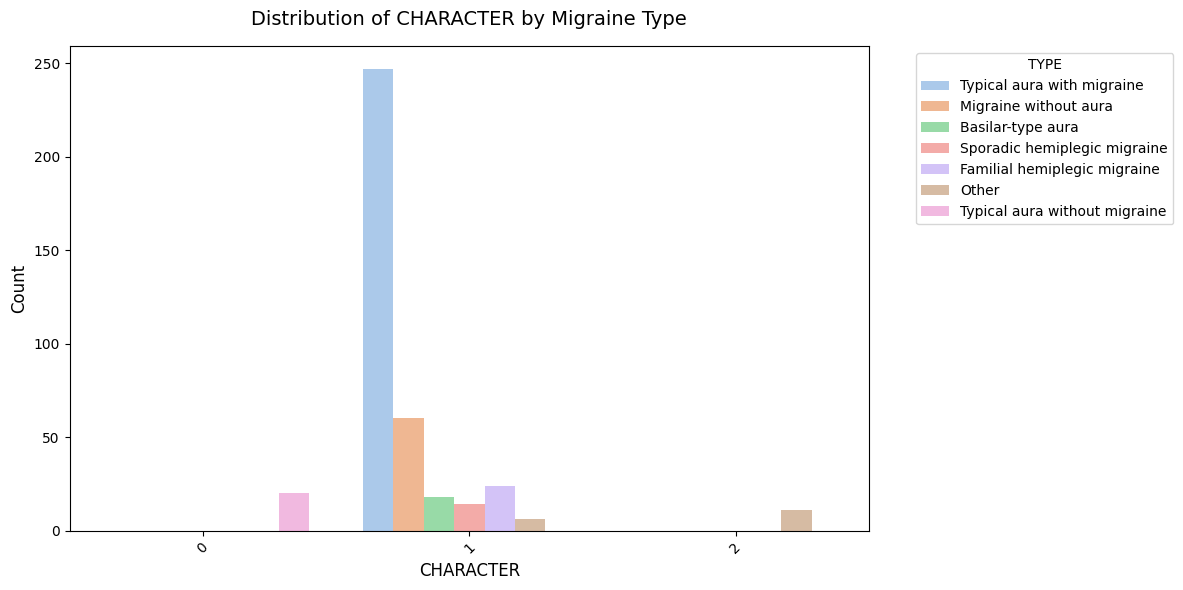

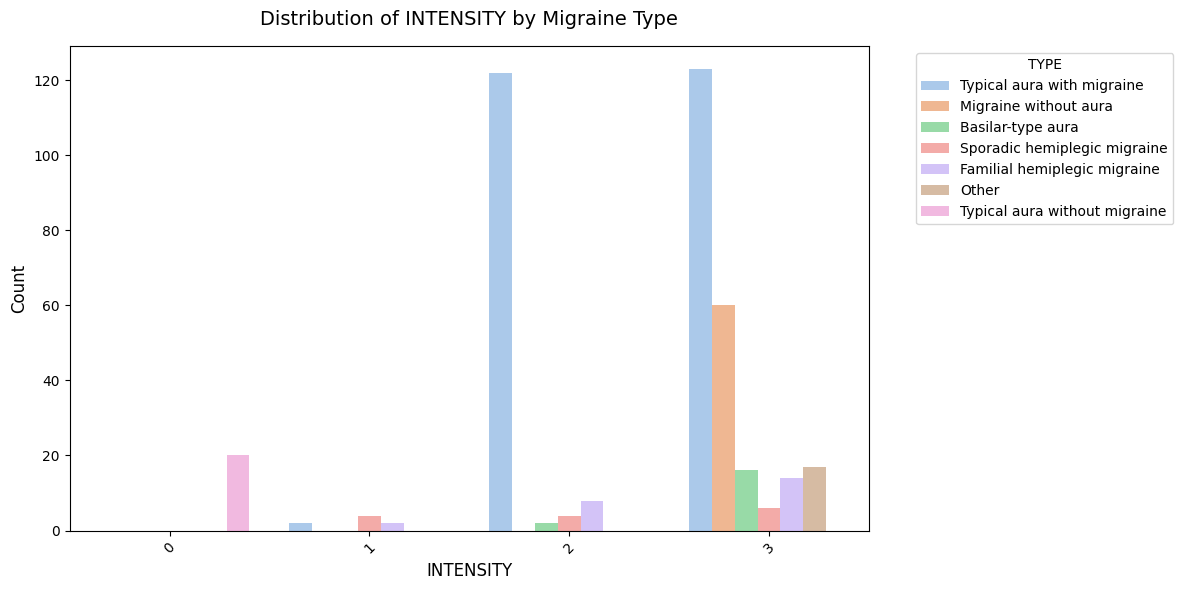

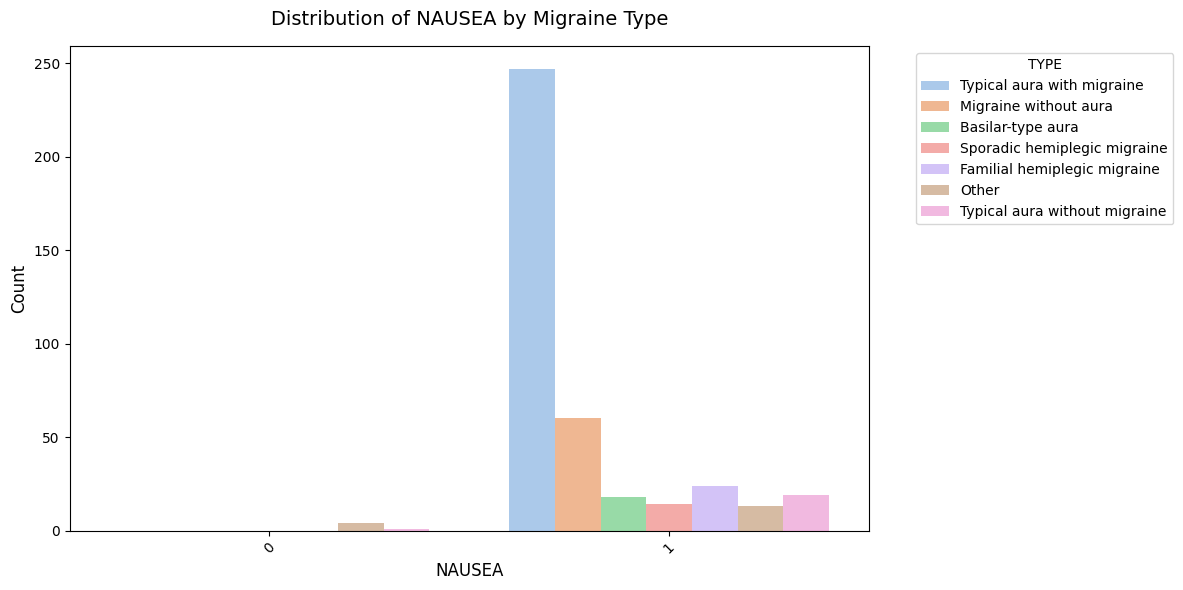

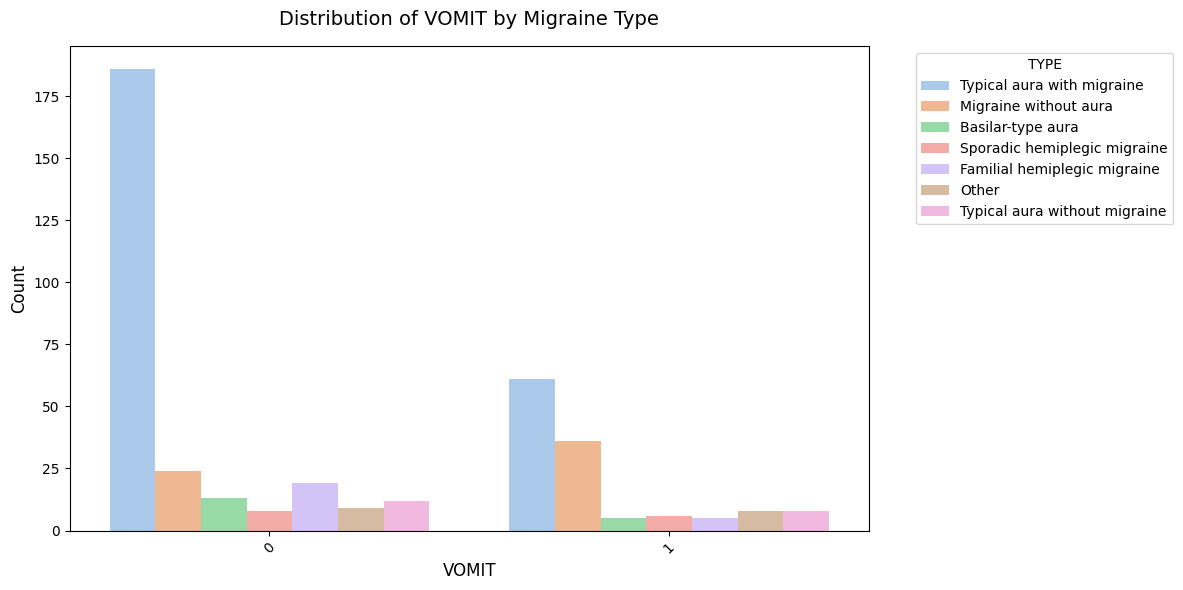

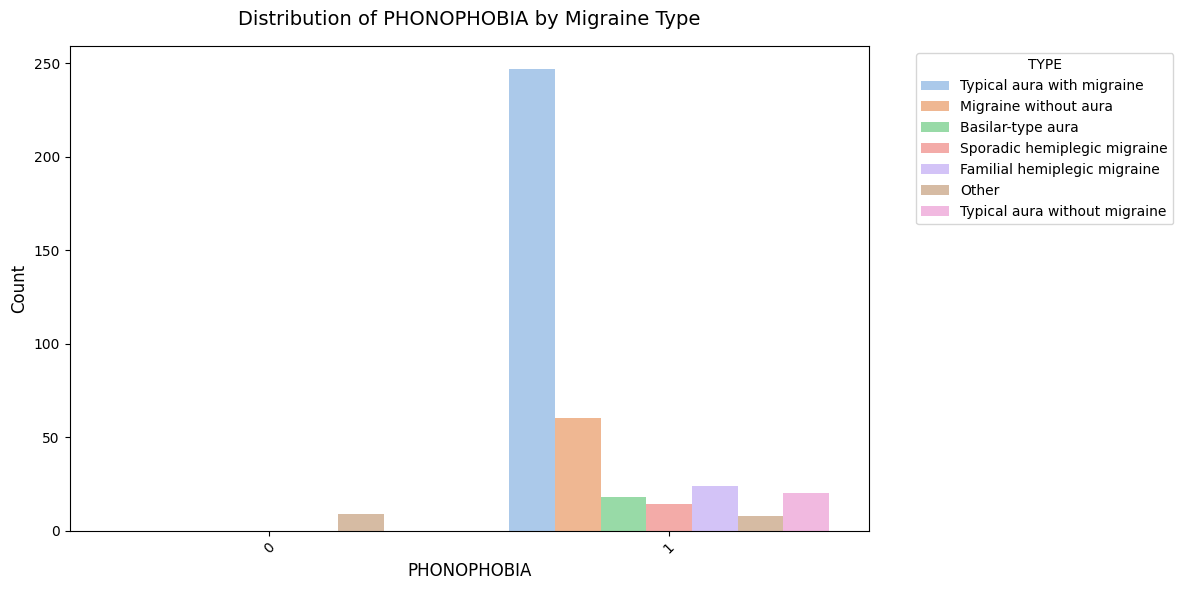

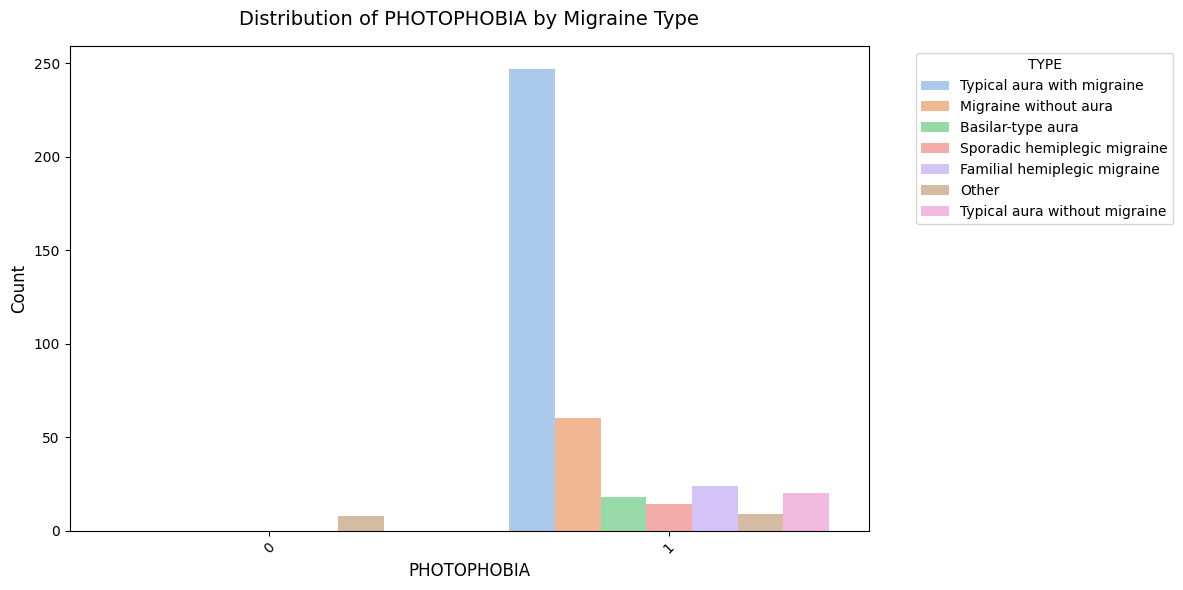

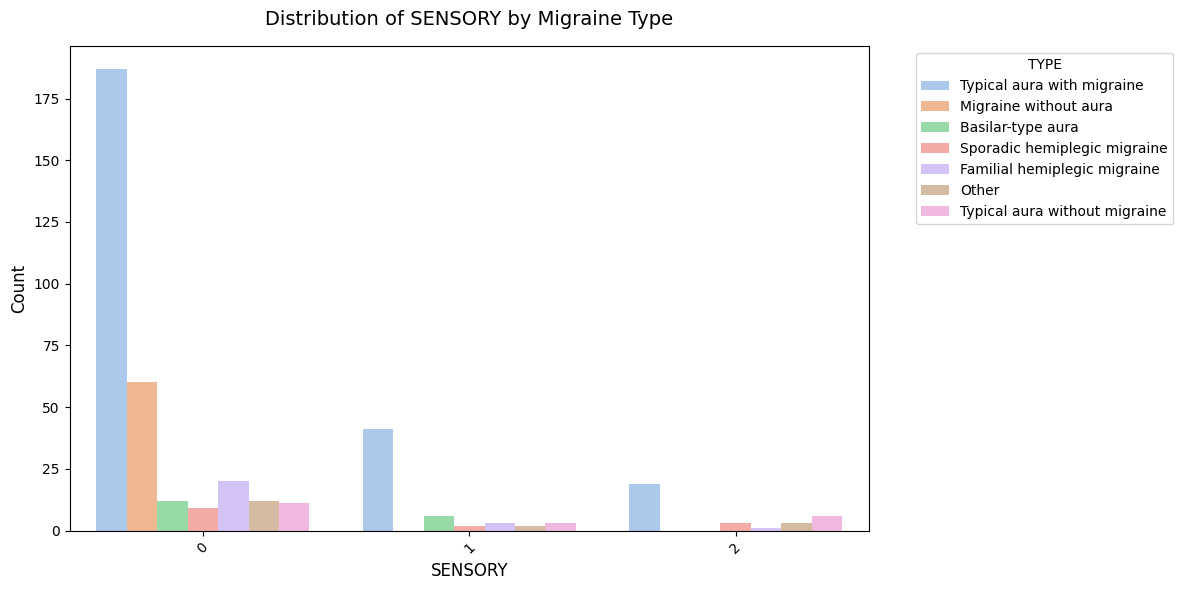

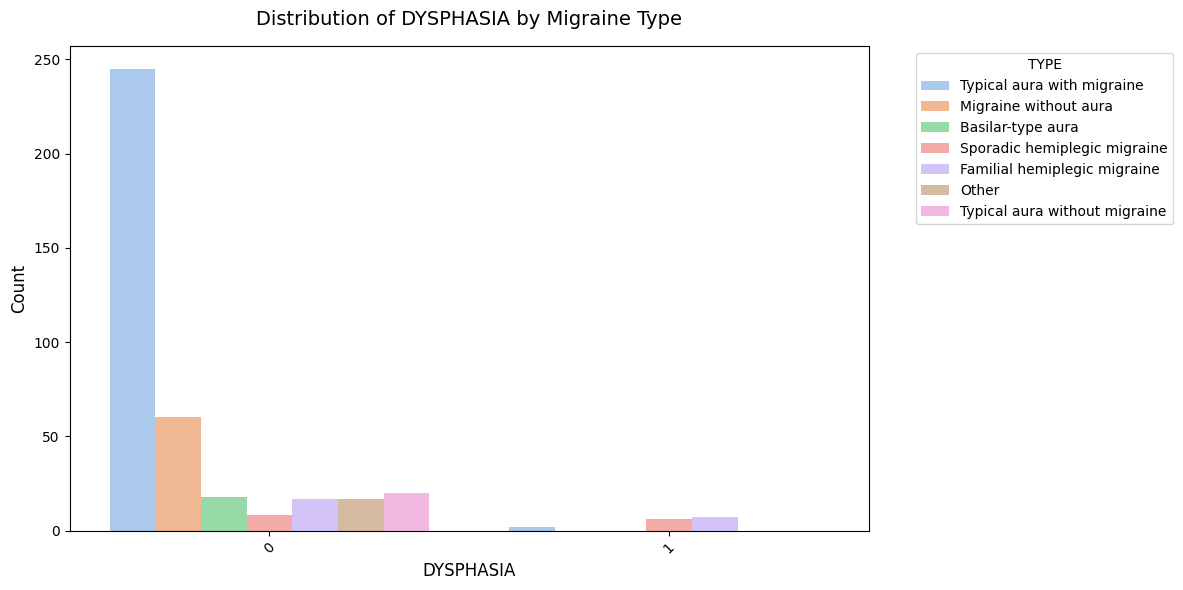

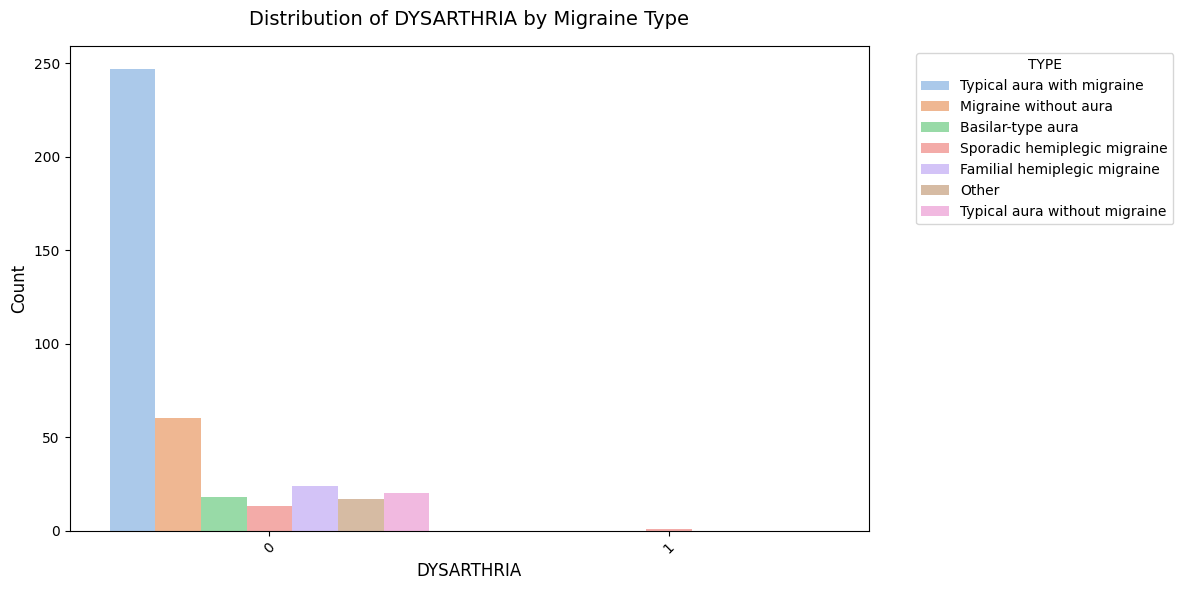

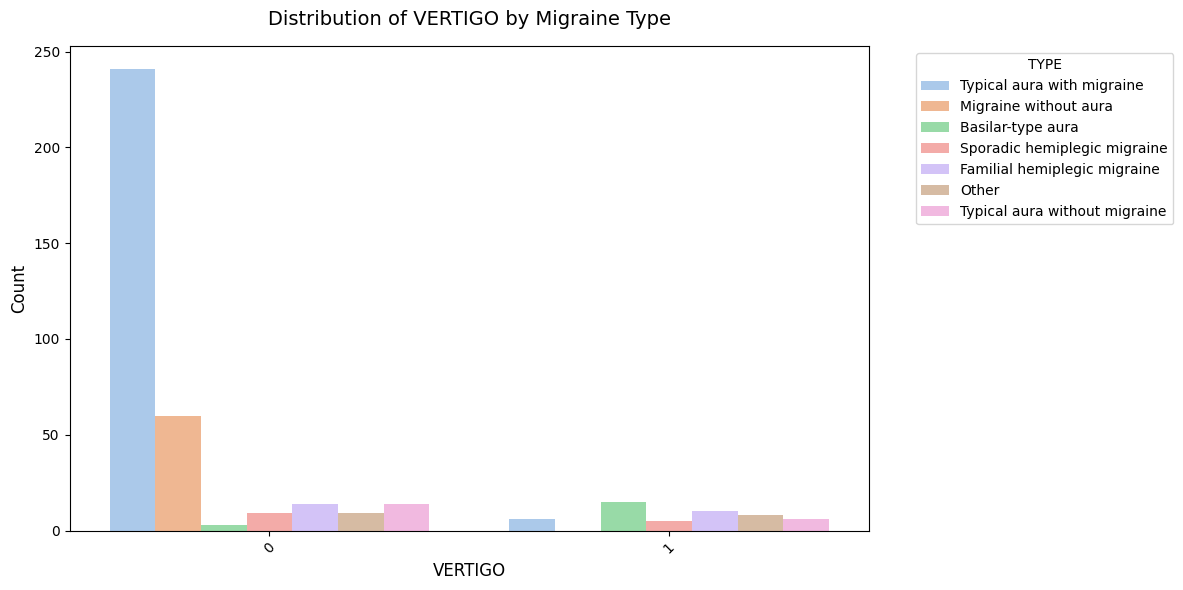

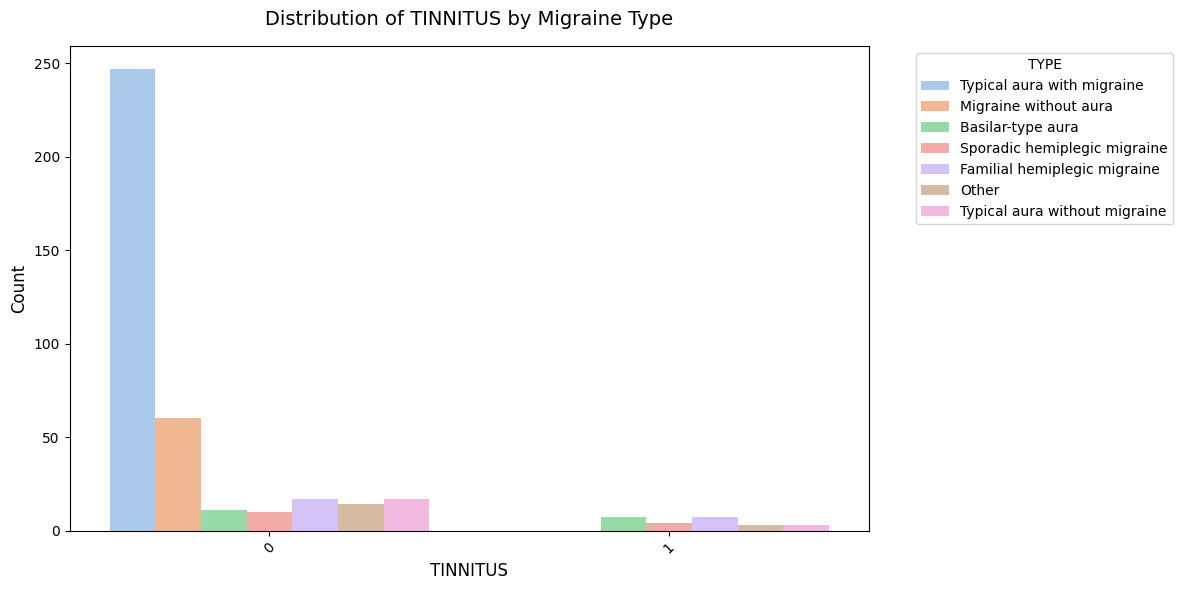

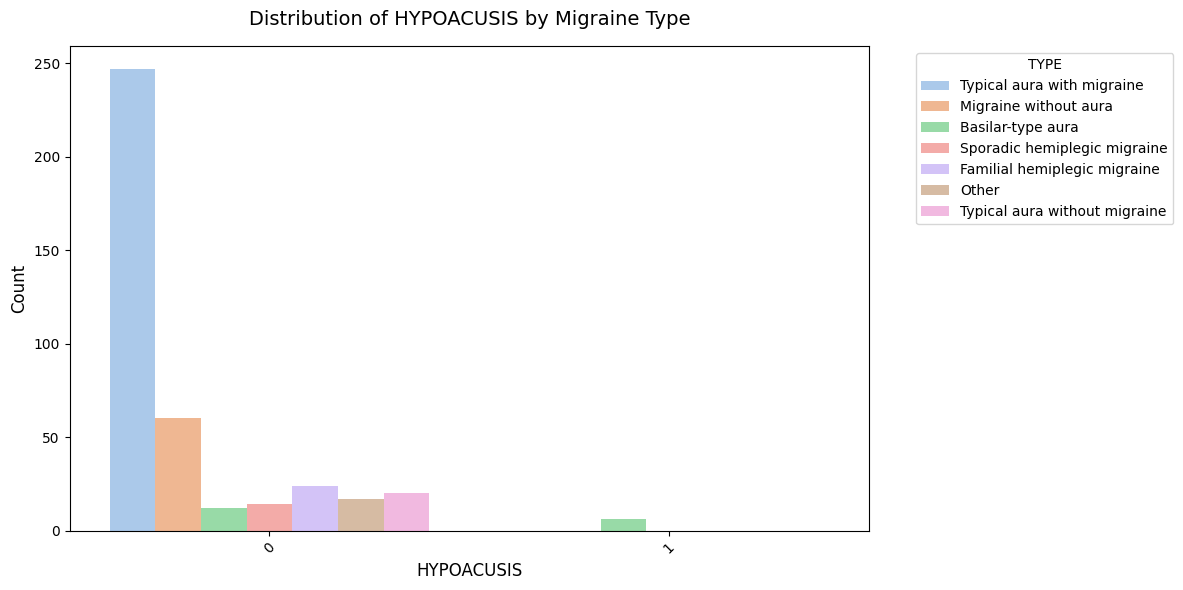

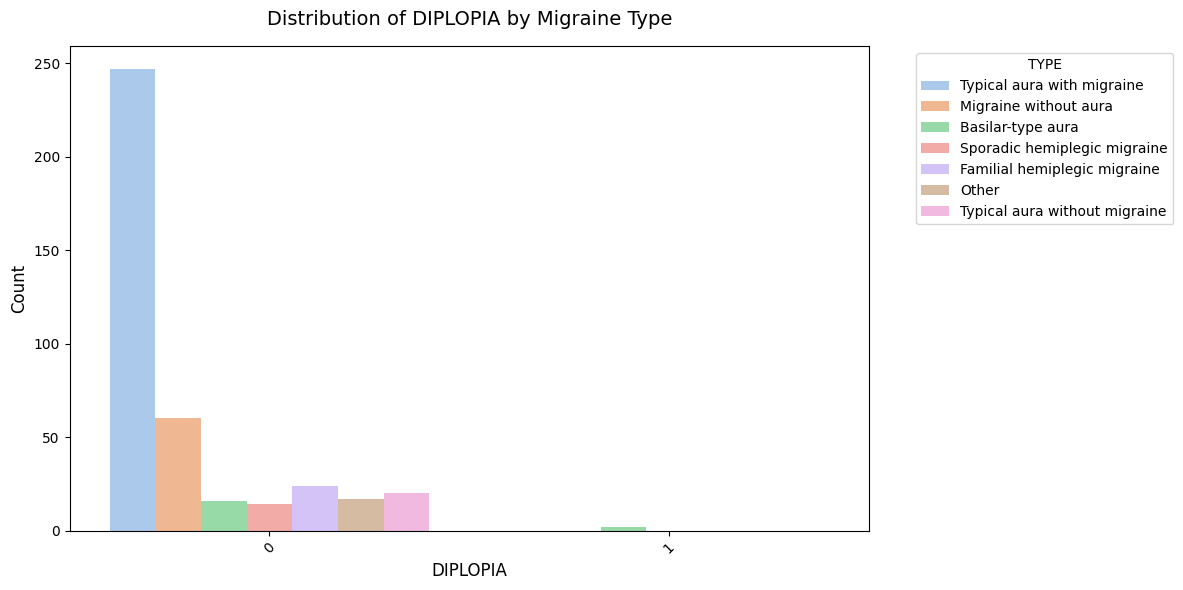

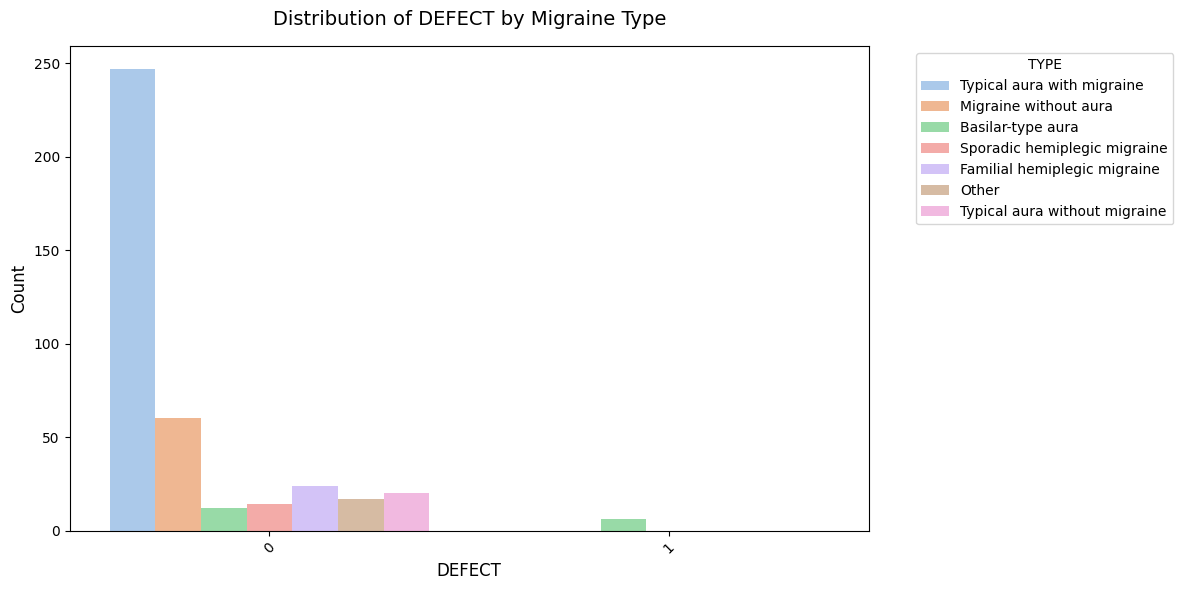

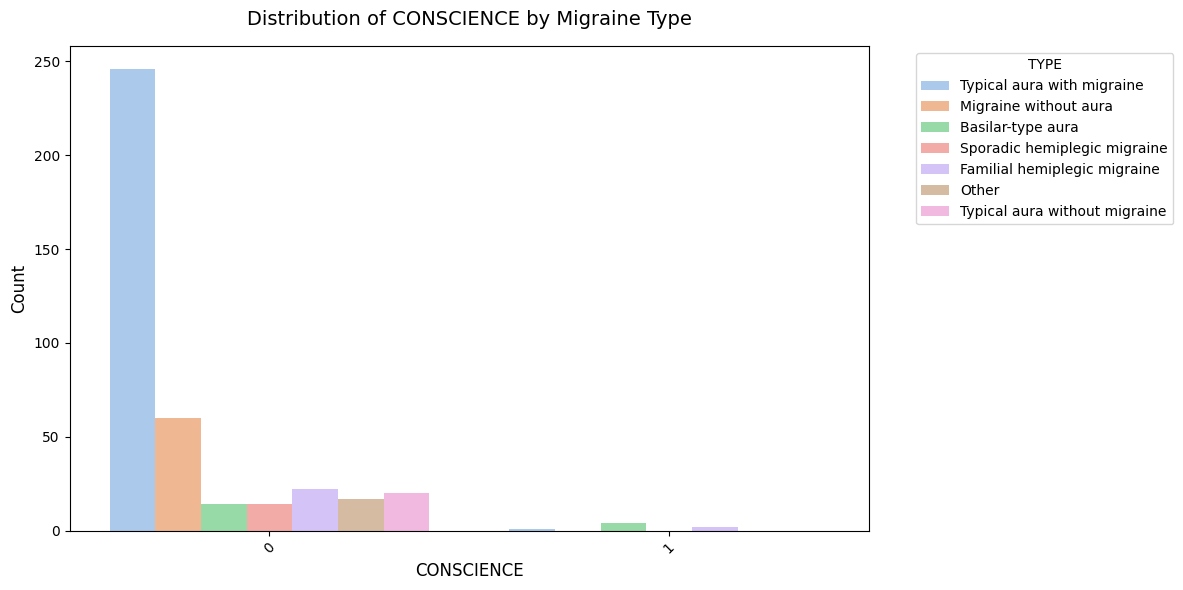

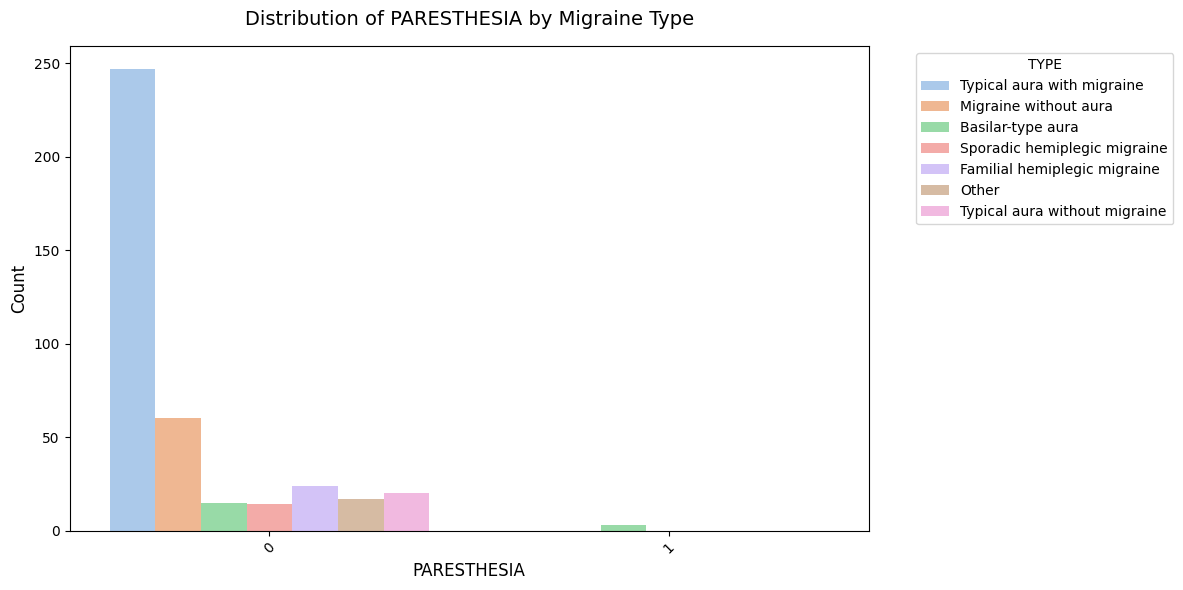

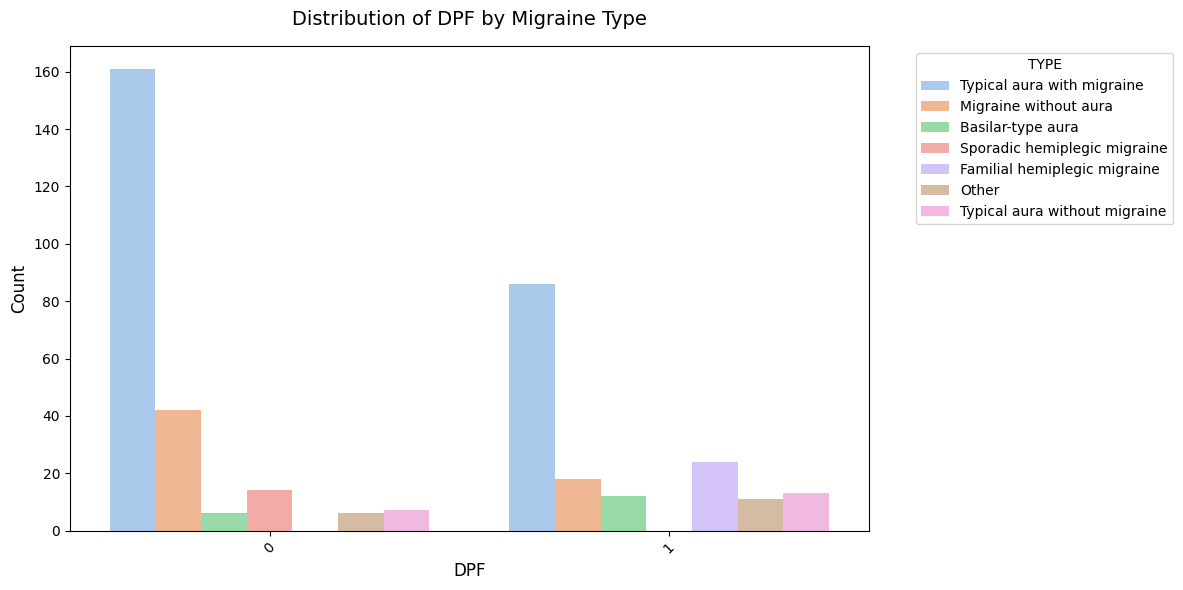

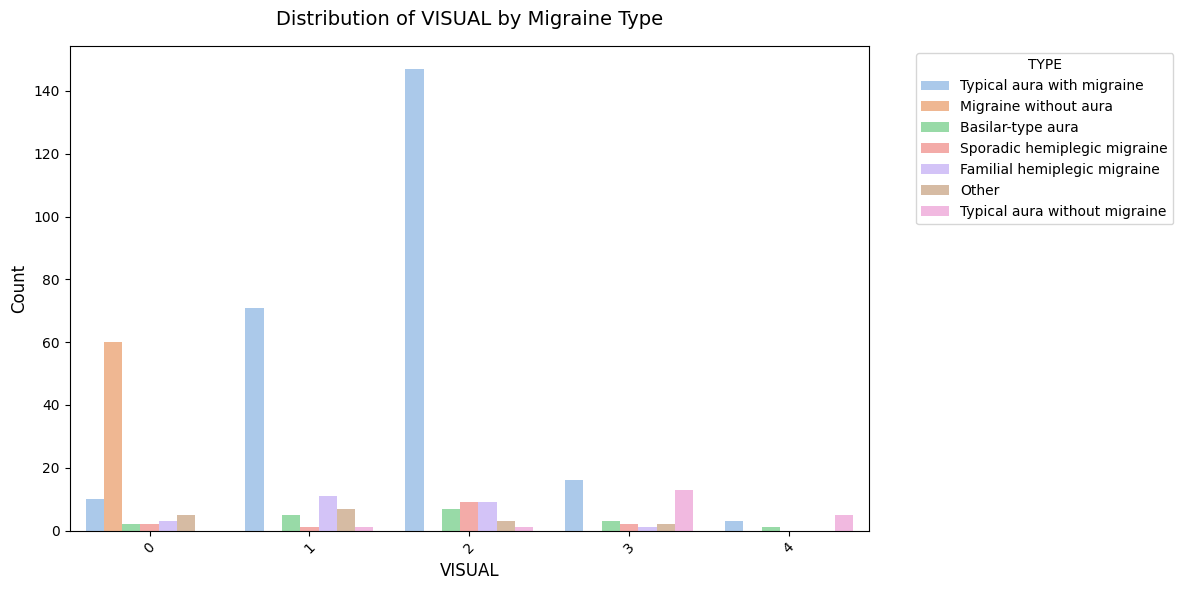

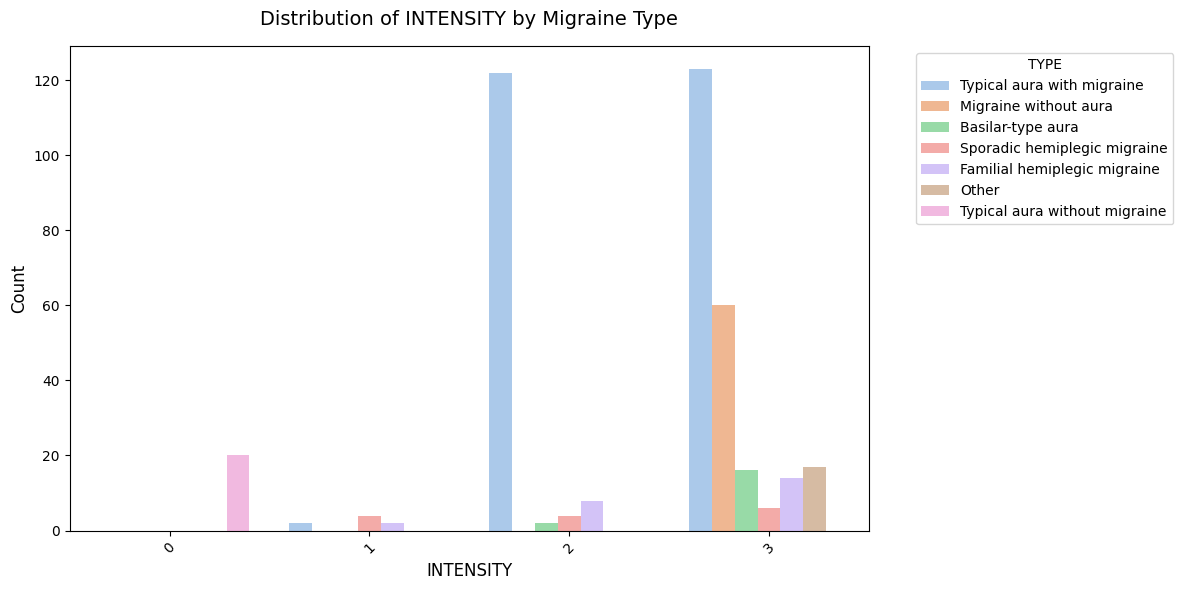

In [10]:
# Check the unique values in the ‘TYPE’ column:
if 'TYPE' in df.columns:
    print(f"'TYPE' column has {df['TYPE'].nunique()} unique values.")
    if df['TYPE'].nunique() <= 1:
        print("The 'TYPE' column has insufficient categories for hue-based plotting.")
    else:
        # Identify the valid categorical columns:
        valid_cat_cols = [col for col in cat_cols if df[col].nunique() > 1]
        print(f"Valid categorical columns: {valid_cat_cols}")

        for col in valid_cat_cols:
            try:
                plt.figure(figsize=(12, 6))
                sns.countplot(data=df, x=col, hue='TYPE', palette="pastel")
                plt.title(f"Distribution of {col} by Migraine Type", fontsize=14, pad=15)
                plt.xticks(rotation=45, fontsize=10)
                plt.yticks(fontsize=10)
                plt.xlabel(col, fontsize=12)
                plt.ylabel("Count", fontsize=12)
                plt.legend(title="TYPE", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error occurred for column {col}: {e}")
else:
    print("The 'TYPE' column is missing in the dataset.")

We examined the distributions of categorical variables in relation to the “TYPE” (migraine type).
These visualizations help us understand the relationship between each categorical feature and the migraine types.

For example:
	•	Variables such as INTENSITY (Severity) and VISUAL (Number of Visual Symptoms) can vary between migraine types.
	•	Symptoms like PHONOPHOBIA, PHOTOPHOBIA, and NAUSEA are common in most migraine types, but their distributions can vary across different types.

### Analysis of the Relationship Between Numeric Variables and the Target Variable (TYPE)

'TYPE' column has 7 unique values.


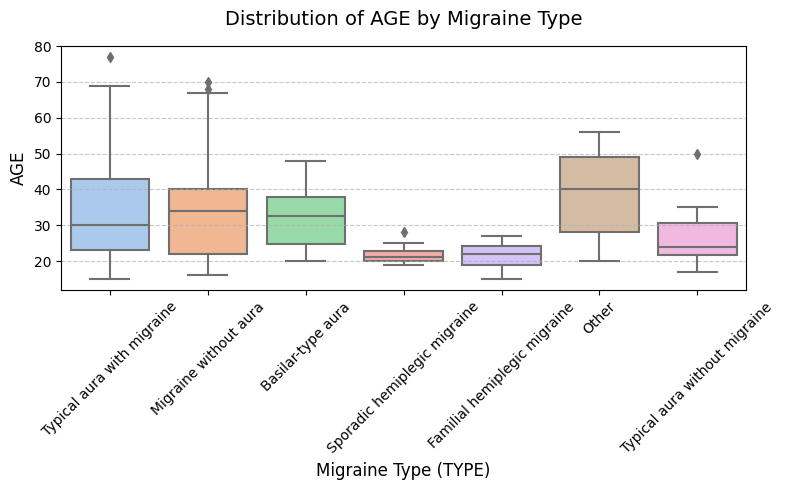

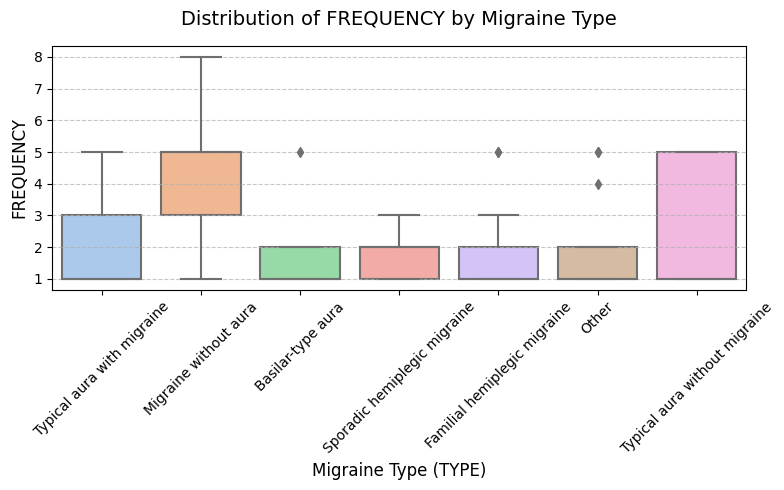

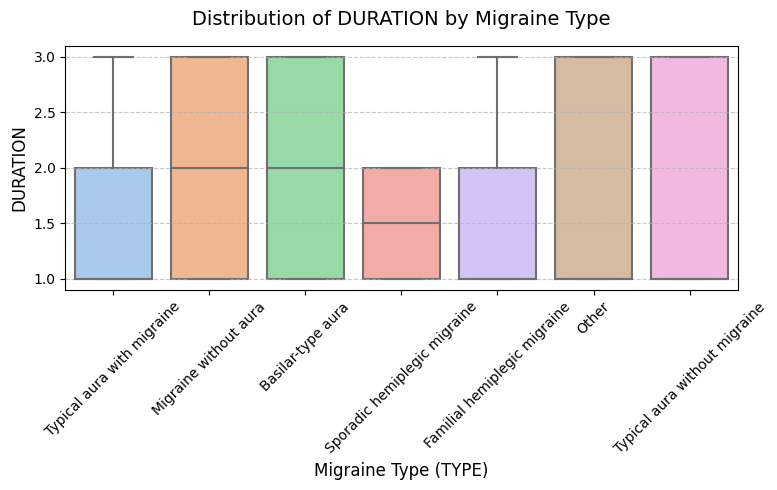

In [11]:
# Check the unique values in the ‘TYPE’ column:
if 'TYPE' in df.columns:
    print(f"'TYPE' column has {df['TYPE'].nunique()} unique values.")

    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x='TYPE', y=col, palette="pastel")
        plt.title(f"Distribution of {col} by Migraine Type", fontsize=14, pad=15)
        plt.xlabel("Migraine Type (TYPE)", fontsize=12)
        plt.ylabel(col, fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    print("The 'TYPE' column is missing in the dataset.")

AGE (Age) and Migraine Type
	1.	In the “Typical aura with migraine” and “Migraine without aura” types, age is distributed over a wide range, with the median age around 30-35.
	2.	For rarer types like “Sporadic hemiplegic migraine” and “Familial hemiplegic migraine,” age is generally younger, with these types being more common in younger age groups.
	3.	The “Other” category shows a wider age distribution.
	4.	Rarer migraine types exhibit distinct age ranges.
	5.	Age could be a distinguishing variable in migraine type classification.

DURATION (Episode Duration) and Migraine Type
	1.	For “Migraine without aura,” “Basilar-type aura,” “Typical aura without migraine,” and “Other” types, episode durations generally cluster between 2-3 days.
	2.	“Sporadic hemiplegic migraine” and “Familial hemiplegic migraine” types have shorter episode durations (1-2 days).
	3.	Rarer types of migraine (e.g., hemiplegic migraines) tend to have shorter episode durations.
	4.	This variable may create a distinction between more common types and rarer types.

FREQUENCY (Episode Frequency) and Migraine Type
	1.	“Typical aura with migraine” and “Migraine without aura” types show varied episode frequencies, but the median frequency is lower.
	2.	“Typical aura without migraine” has the highest episode frequency compared to other types.
	3.	In rarer types (e.g., “Familial hemiplegic migraine,” “Sporadic hemiplegic migraine”), episode frequency is relatively low.
	4.	Episode frequency can help differentiate more common migraine types from rarer types.
	5.	The higher episode frequency of “Typical aura without migraine” distinguishes it from the others.

Discriminative Variables:
	1.	The AGE variable could be effective in distinguishing rarer migraine types, especially in younger age groups.
	2.	DURATION is important for showing differences between migraine types.
	3.	FREQUENCY could be useful in differentiating common migraine types from rarer ones.

Modeling Recommendations:
	1.	These variables could serve as effective features in classifying the target variable.
	2.	Analyzing the weights and importance of these variables during model optimization will be beneficial.

# Encoding

In [12]:
# Perform Label Encoding on the “INTENSITY” column (since it is ordinal):
label_encoder = LabelEncoder()
df["INTENSITY"] = label_encoder.fit_transform(df["INTENSITY"])

# Perform One-Hot Encoding for nominal categorical variables:
nominal_cols = ["CHARACTER", "LOCATION", "SENSORY", "VISUAL"]
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)


Nominal Categorical Variables: CHARACTER, LOCATION, SENSORY, VISUAL
One-Hot Encoding was applied to these variables.

Ordinal Categorical Variable: INTENSITY
Label Encoding was used to maintain its ordered structure.

Binary Categorical Variables: NAUSEA, VOMIT, PHONOPHOBIA, PHOTOPHOBIA
These variables are already encoded as 0/1, so no additional encoding was applied.

# Standardization

Since you will be using tree-based methods, such as decision trees or random forests, there is no need to perform standardization. Tree-based algorithms are not sensitive to the scale of the data, so the model will work effectively without scaling the features.

# Base Model Setup


In [13]:
df_base = df.copy()

# Encode our target variable:
df_base['TYPE'] = df_base['TYPE'].replace({
    'Typical aura with migraine': 0,
    'Migraine without aura': 1,
    'Basilar-type aura': 2,
    'Sporadic hemiplegic migraine': 3,
    'Familial hemiplegic migraine': 4,
    'Other': 5,
    'Typical aura without migraine': 6
})

# Separate our dependent and independent variables:
X_base = df_base.drop(columns=["TYPE"]) 
Y_base = df_base["TYPE"]

# Split the data into training and testing sets:
X_train_base, X_test_base, Y_train_base, Y_test_base = train_test_split(X_base, Y_base, test_size=0.3, random_state=42)

# Define our base models:
base_models = [
    ("CART", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("XGBoost", XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)),
    ("LightGBM", LGBMClassifier(verbose=-1, random_state=42))
]

# Create an empty dictionary to evaluate the models and store the results:
base_results = {}

for name, model in base_models:
    try:
        print(f"Evaluating {name}...")
        # Train the models and make predictions
        model.fit(X_train_base, Y_train_base)
        Y_pred_base = model.predict(X_test_base)

        # Classification Report
        print(f"{name} Classification Report:")
        print(classification_report(Y_test_base, Y_pred_base))

        # 10-fold cross-validation
        cv_results = cross_validate(model, X_base, Y_base, cv=10, scoring="accuracy", n_jobs=-1)
        base_results[name] = cv_results["test_score"].mean()  # Ortalama doğruluk skoru
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

# Show the base model results
print("\nBase Model Accuracy Scores:")
for model_name, score in base_results.items():
    print(f"{model_name}: {score:.4f}")

Evaluating CART...
CART Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        73
           1       0.79      1.00      0.88        19
           2       0.50      0.25      0.33         8
           3       0.14      0.33      0.20         3
           4       0.20      0.33      0.25         6
           5       1.00      0.67      0.80         6
           6       1.00      1.00      1.00         5

    accuracy                           0.78       120
   macro avg       0.65      0.63      0.62       120
weighted avg       0.82      0.78      0.79       120

Evaluating Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        73
           1       0.85      0.89      0.87        19
           2       0.83      0.62      0.71         8
           3       0.50      0.33      0.40         3
           4       0

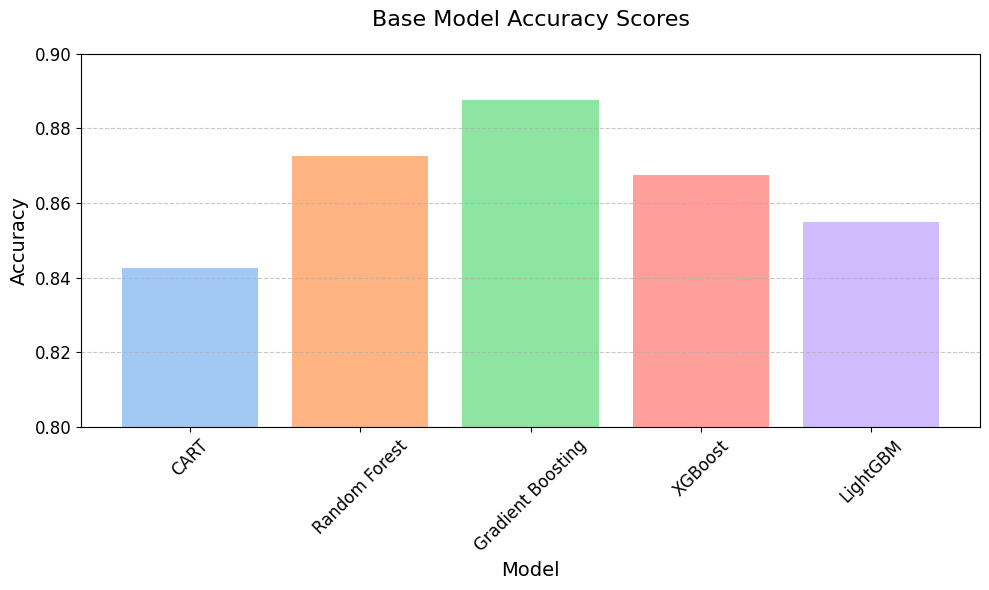

In [14]:
# Visualize the results of your base models

# Convert the base model results into a pandas DataFrame:
results_df = pd.DataFrame(list(base_results.items()), columns=["Model", "Accuracy"])

# Create a bar chart to visualize the base model results:
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Accuracy"], color=sns.color_palette("pastel"))
plt.title("Base Model Accuracy Scores", fontsize=16, pad=20)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0.8, 0.9)  
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Feature Engineering

In [15]:
df["FREQUENCY_PER_AGE"] = df["FREQUENCY"] / (df['AGE'] + 1e-3)  # Add a small constant to avoid division by zero error

df["DURATION_PER_AGE"] = df["DURATION"] / (df["AGE"] + 1e-3)

df["INTENSITY_FREQUENCY_PRODUCT"] = df["INTENSITY"] * df["FREQUENCY"]

df["PAIN_SUMMARY"] = ( df["CHARACTER_1"] + df["CHARACTER_2"] + df["INTENSITY"] + df["LOCATION_1"] + df["LOCATION_2"])

df["SENSITIVITY_SCORE"] = (df["PHONOPHOBIA"] + df["PHOTOPHOBIA"] + df["NAUSEA"])

df["PAIN_SENSITIVITY"] = df["INTENSITY"] * df["SENSITIVITY_SCORE"]

df["AGE_DURATION_FREQUENCY_COMBO"] = df["AGE"] + df["DURATION"] + df["FREQUENCY"]

In [16]:
df.shape

(400, 37)

### Correlation Analysis with the Newly Created Features

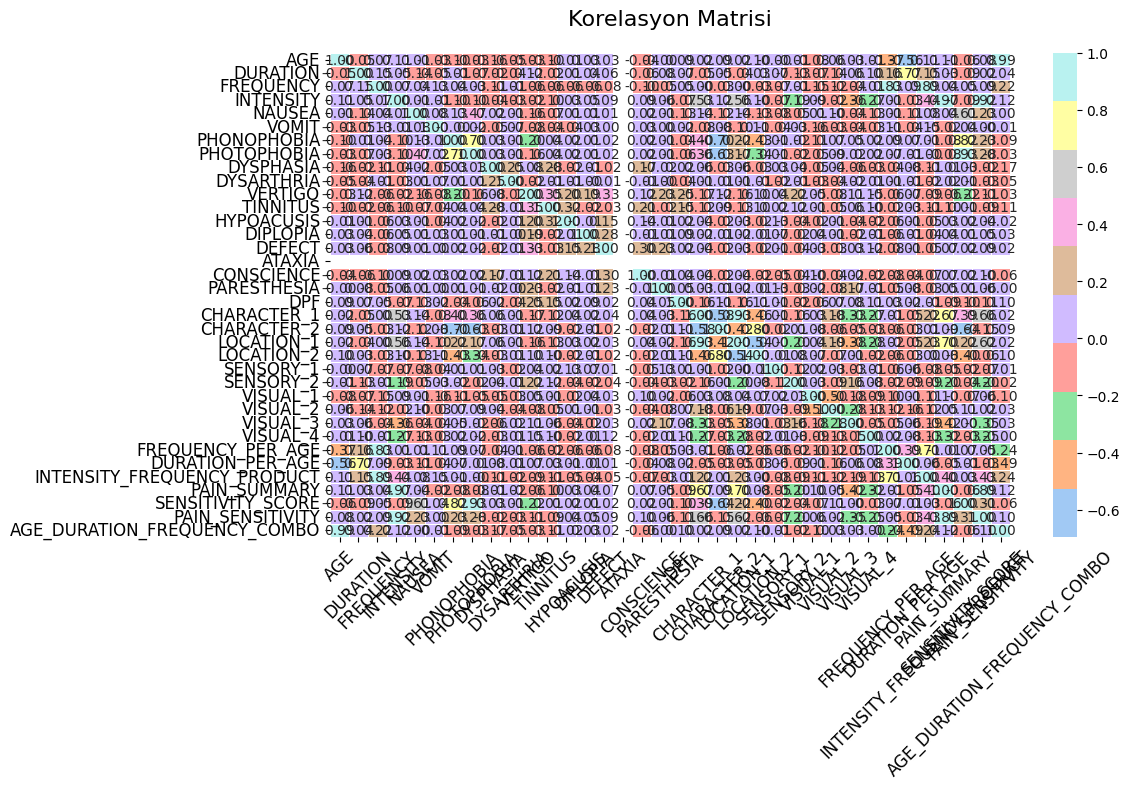

In [17]:
# Select all numerical columns except for the “TYPE” column (since we haven’t encoded the “TYPE” column)
numeric_df = df.select_dtypes(include=['number'])  
numeric_df = numeric_df.loc[:, numeric_df.columns != 'TYPE'] 

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=sns.color_palette("pastel", as_cmap=True),
    fmt=".2f",
    linewidths=0.5
)
plt.title("Korelasyon Matrisi", fontsize=16, pad=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [18]:
# Since there are many variables, the visualization is complex. To see the highly correlated variables:
# Set a correlation threshold to filter the highly correlated variables:
correlation_threshold = 0.8

# Filter the pairs by taking the upper triangle
high_corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Select the pairs above the threshold value
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > correlation_threshold]

print(high_corr_pairs)

        Variable1                     Variable2  Correlation
33            AGE  AGE_DURATION_FREQUENCY_COMBO        0.988
92      FREQUENCY             FREQUENCY_PER_AGE        0.831
94      FREQUENCY   INTENSITY_FREQUENCY_PRODUCT        0.887
126     INTENSITY                  PAIN_SUMMARY        0.965
128     INTENSITY              PAIN_SENSITIVITY        0.919
214   PHONOPHOBIA             SENSITIVITY_SCORE        0.818
241   PHOTOPHOBIA             SENSITIVITY_SCORE        0.926
460   CHARACTER_1                    LOCATION_1        0.929
590  PAIN_SUMMARY              PAIN_SENSITIVITY        0.894


# Machine Learning

In [19]:
data_1 = df[df['TYPE'] == 'Typical aura with migraine']
data_2 = df[df['TYPE'] == 'Migraine without aura']
data_3 = df[df['TYPE'] == 'Familial hemiplegic migraine']
data_4 = df[df['TYPE'] == 'Typical aura without migraine']
data_5 = df[df['TYPE'] == 'Basilar-type aura']
data_6 = df[df['TYPE'] == 'Other']
data_7 = df[df['TYPE'] == 'Sporadic hemiplegic migraine']

data_1_resample = resample(data_1, n_samples=247,
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=247,
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=247,
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=247,
                           random_state=123, replace=True)
data_5_resample = resample(data_5, n_samples=247,
                           random_state=123, replace=True)
data_6_resample = resample(data_6, n_samples=247,
                           random_state=123, replace=True)
data_7_resample = resample(data_7, n_samples=247,
                           random_state=123, replace=True)


df = pd.concat([data_1, data_2_resample, data_3_resample, data_4_resample,
                          data_5_resample, data_6_resample, data_7_resample])


df['TYPE'] = df['TYPE'].replace({'Typical aura with migraine': 0,
                                 'Migraine without aura': 1, 'Basilar-type aura': 2,
                                 'Sporadic hemiplegic migraine': 3, 'Familial hemiplegic migraine': 4,
                                 'Other': 5, 'Typical aura without migraine': 6})

df = df.drop(columns=[
    "ATAXIA",
    "AGE_DURATION_FREQUENCY_COMBO",
    "FREQUENCY_PER_AGE",
    "INTENSITY_FREQUENCY_PRODUCT",
    "PAIN_SUMMARY",
    "PAIN_SENSITIVITY"
])

	1.	Data Splitting: The dataset is split by migraine types (TYPE column), creating separate subsets for each type (data_1 to data_7).
	2.	Resampling: All subsets except data_1 are resampled to 247 samples each, balancing the dataset.
	3.	Concatenation: The resampled subsets are combined into a single dataframe (df) with 1729 rows and 37 columns.
	4.	Target Encoding: The TYPE column is encoded with numerical values (0 to 6) corresponding to each migraine type.
	5.	Dropping Columns: Irrelevant columns are removed from the dataframe to focus on essential features for modeling.

In [20]:
X = df.drop(columns=["TYPE"])
Y = df["TYPE"]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=15)

### CART

In [21]:
cart_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 20).fit(X_train, Y_train)

# Training error

Y_pred =cart_model.predict(X_train)
Y_prob =cart_model.predict_proba(X_train)[:,1]
print(classification_report(Y_train, Y_pred))

# Testing error

Y_pred =cart_model.predict(X_test)
Y_prob =cart_model.predict_proba(X_test)[:,1]
print(classification_report(Y_test, Y_pred))


# Cross-Validation success evaluation

cv_results = cross_validate(cart_model, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       177
           2       1.00      1.00      1.00       174
           3       1.00      1.00      1.00       172
           4       1.00      1.00      1.00       182
           5       1.00      1.00      1.00       169
           6       1.00      1.00      1.00       164

    accuracy                           1.00      1210
   macro avg       1.00      1.00      1.00      1210
weighted avg       1.00      1.00      1.00      1210

              precision    recall  f1-score   support

           0       0.96      0.87      0.91        75
           1       0.96      0.96      0.96        70
           2       1.00      1.00      1.00        73
           3       0.95      1.00      0.97        75
           4       0.97      1.00      0.98        65
           5       0.99      1.00      0.99        78
           6       1.00 

0.9814928081731417

### Random Forest

In [22]:
rf_model = RandomForestClassifier(random_state=20).fit(X_train,Y_train)
rf_model.get_params()

# Training error

Y_pred =rf_model.predict(X_train)
Y_prob =rf_model.predict_proba(X_train)[:,1]
print(classification_report(Y_train, Y_pred))

# Testing error

Y_pred =rf_model.predict(X_test)
Y_prob =rf_model.predict_proba(X_test)[:,1]
print(classification_report(Y_test, Y_pred))

# Cross-Validation success evaluation

rf_params = {"max_depth": [5,8,20,None],
             "max_features": [3,5,7,15,"sqrt"],
              "min_samples_split": [2,5,15,20],
          "n_estimators": [100, 200, 500]}
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, Y)
rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X,Y)
cv_results = cross_validate(rf_final, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       177
           2       1.00      1.00      1.00       174
           3       1.00      1.00      1.00       172
           4       1.00      1.00      1.00       182
           5       1.00      1.00      1.00       169
           6       1.00      1.00      1.00       164

    accuracy                           1.00      1210
   macro avg       1.00      1.00      1.00      1210
weighted avg       1.00      1.00      1.00      1210

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        75
           1       0.97      0.97      0.97        70
           2       1.00      1.00      1.00        73
           3       1.00      1.00      1.00        75
           4       0.94      1.00      0.97        65
           5       1.00      1.00      1.00        78
           6       1.00 

0.9930635838150289

### Gradient Boosting Machines

In [23]:
gbm_model = GradientBoostingClassifier(random_state = 42)
gbm_model.get_params()
cv_results = cross_validate(gbm_model, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()

gbm_params = {"learning_rate": [0.1, 0.15, 0.2, 0.25],
              "max_depth": [3, 8, 20],
              "n_estimators": [100, 200],
              "subsample": [1.0, 1.7, 2.0]}
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=10, n_jobs=-1, verbose=True).fit(X, Y)
gbm_best_grid.best_params_

gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=15).fit(X,Y)
cv_results = cross_validate(gbm_final, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.9919041537841107

### XG Boost

In [24]:
XGBoost_model = XGBClassifier(random_state=40)
cv_results = cross_validate(XGBoost_model, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()

XGBoost_model.get_params()
XGBoost_params = {"learning_rate": [0.1, 0.15, 0.2, 0.25, None],
              "max_depth": [3, 8, 20, None],
              "n_estimators": [100, 200, None],
              "colsample_bytree": [1.0, 1.7, 2.0, None]}
XGBoost_best_grid = GridSearchCV(XGBoost_model, XGBoost_params, cv=10, n_jobs=-1, verbose=True).fit(X, Y)
XGBoost_best_grid.best_params_


XGBoost_final = XGBoost_model.set_params(**XGBoost_best_grid.best_params_, random_state=15).fit(X,Y)
cv_results = cross_validate(XGBoost_final, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


0.9901666890711116

### LightGBM

In [25]:
lgbm_model = LGBMClassifier(random_state=45, verbose=-1)
cv_results = cross_validate(lgbm_model, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()


lgbm_model.get_params()
lgbm_params = {"learning_rate": [0.1, 0.15, 0.2, 0.25],
              "max_depth": [-1, 3, 8, 20],
              "n_estimators": [100, 200],
              "colsample_bytree": [0.6, 0.8, 1.0]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=10, n_jobs=-1, verbose=True).fit(X, Y)
lgbm_best_grid.best_params_

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=15).fit(X,Y)
cv_results = cross_validate(lgbm_final, X, Y,
                              cv=10, scoring= ["accuracy", "precision", "recall", "f1"])
cv_results['test_accuracy'].mean()

Fitting 10 folds for each of 96 candidates, totalling 960 fits


0.9913294797687862

##### Confusion Matrix

[[75  0  0  0  0  0  0]
 [ 0 70  0  0  0  0  0]
 [ 0  0 73  0  0  0  0]
 [ 0  0  0 75  0  0  0]
 [ 0  0  0  0 65  0  0]
 [ 0  0  0  0  0 78  0]
 [ 0  0  0  0  0  0 83]]


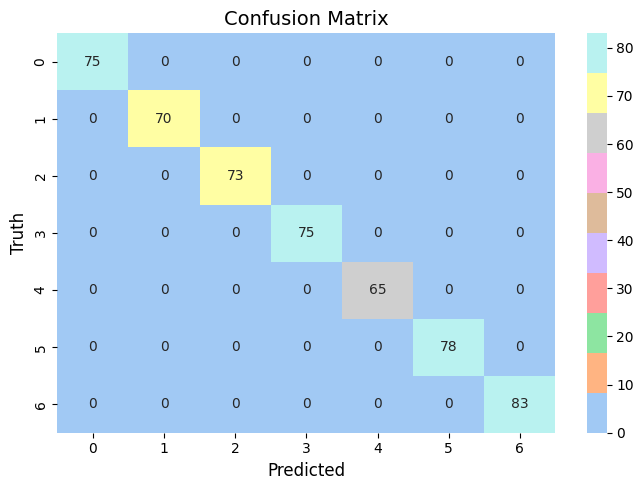

In [26]:
Y_pred = lgbm_final.predict(X_test)
CM = confusion_matrix(Y_test, Y_pred)
print(CM)


plt.figure(figsize=(7, 5))
sns.heatmap(
    CM,
    annot=True,
    fmt='d',
    cmap=sns.color_palette("pastel", as_cmap=True)  
)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Truth', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [27]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        70
           2       1.00      1.00      1.00        73
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00        78
           6       1.00      1.00      1.00        83

    accuracy                           1.00       519
   macro avg       1.00      1.00      1.00       519
weighted avg       1.00      1.00      1.00       519



CM, the confusion matrix, is a matrix that compares the predicted classes (Y_pred) with the actual classes (Y_test). It shows which classes were correctly predicted and where errors occurred.

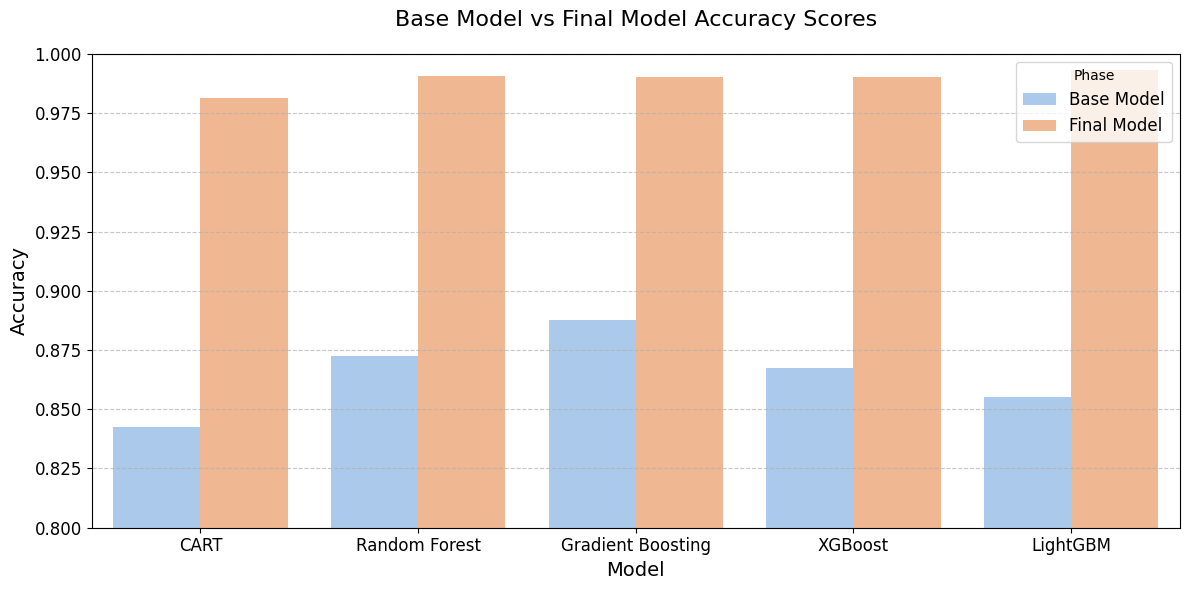

In [28]:
# Create a visualization to display and compare the results of our Base Model and the Model after Feature Engineering:

# Base Model Accuracy Scores
base_model_results = {
    "CART": 0.8425,
    "Random Forest": 0.8725,
    "Gradient Boosting": 0.8875,
    "XGBoost": 0.8675,
    "LightGBM": 0.8550
}

# Post-Feature Engineering Model Accuracy Scores
final_model_results = {
    "CART": 0.9815,
    "Random Forest": 0.9907,
    "Gradient Boosting": 0.9902,
    "XGBoost": 0.9902,
    "LightGBM": 0.9930
}

# Convert the data into a DataFrame:
results_df = pd.DataFrame({
    "Model": list(base_model_results.keys()),
    "Base Model": list(base_model_results.values()),
    "Final Model": list(final_model_results.values())
})

# Reshape the wide DataFrame into a long format:
results_df_long = results_df.melt(id_vars="Model", var_name="Phase", value_name="Accuracy")

# Plot a bar chart:
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df_long, x="Model", y="Accuracy", hue="Phase", palette="pastel")
plt.title("Base Model vs Final Model Accuracy Scores", fontsize=16, pad=20)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0.8, 1.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Phase", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Feature Importance

              Feature  Importance
0                 AGE        4689
28   DURATION_PER_AGE        4038
2           FREQUENCY        1718
3           INTENSITY        1211
25           VISUAL_2        1113
5               VOMIT         838
17                DPF         770
10            VERTIGO         710
24           VISUAL_1         659
1            DURATION         659
11           TINNITUS         456
22          SENSORY_1         456
8           DYSPHASIA         405
23          SENSORY_2         377
18        CHARACTER_1         253
26           VISUAL_3         238
27           VISUAL_4         203
20         LOCATION_1         191
29  SENSITIVITY_SCORE         166
4              NAUSEA         136


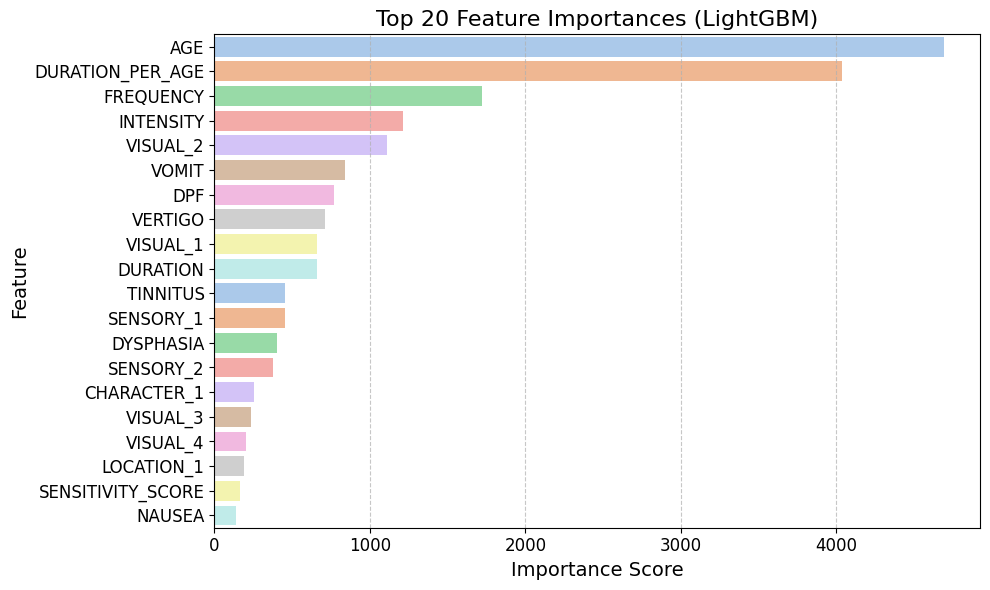

In [29]:
# Obtain the feature importance levels:
feature_importances = lgbm_final.feature_importances_
features = X.columns

# Organize the feature importance levels into a DataFrame:
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)


print(importance_df.head(20))


plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x="Importance", y="Feature", palette="pastel")
plt.title("Top 20 Feature Importances (LightGBM)", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

